In [1]:
# Define experiment parameters
year = "201516"
target_col = "blue_collar"  # 'white_collar', 'blue_collar', 'has_occ'
sample_weight_col = 'women_weight'

In [2]:
# Define resource utilization parameters
random_state = 42
n_jobs_clf = 16
n_jobs_cv = 4
cv_folds = 5

In [3]:
import numpy as np
np.random.seed(random_state)

import pandas as pd
pd.set_option('display.max_columns', 500)

import matplotlib.pylab as pl

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.utils.class_weight import compute_class_weight

import lightgbm
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

import shap

import pickle
from joblib import dump, load

---

# Prepare Dataset

In [4]:
# Load dataset
dataset = pd.read_csv(f"data/women_work_data_{year}.csv")
print("Loaded dataset: ", dataset.shape)
dataset.head()

Loaded dataset:  (111398, 26)


Unnamed: 0  case_id_str  line_no country_code  cluster_no  hh_no  \
0           8    1000117.0        2          IA6       10001     17   
1           9    1000120.0        1          IA6       10001     20   
2          11    1000129.0        2          IA6       10001     29   
3          12    1000129.0        3          IA6       10001     29   
4          13    1000130.0        2          IA6       10001     30   

                         state wealth_index hh_religion                 caste  \
0  andaman and nicobar islands       middle       hindu                   NaN   
1  andaman and nicobar islands       richer       hindu         none of above   
2  andaman and nicobar islands      richest      muslim  other backward class   
3  andaman and nicobar islands      richest      muslim  other backward class   
4  andaman and nicobar islands       richer   christian       scheduled caste   

   women_weight  women_anemic  obese_female  urban  freq_tv   age  occupation  \
0      0.191636           1.0           0.0    1.0      3.0  23.0         0.0   
1      0.191636           0.0           0.0    1.0      3.0  35.0         8.0   
2      0.191636           1.0           0.0    1.0      3.0  46.0         0.0   
3      0.191636           1.0           0.0    1.0      3.0  17.0         0.0   
4      0.191636           1.0           1.0    1.0      3.0  30.0         0.0   

   years_edu  hh_members  no_children_below5  white_collar  blue_collar  \
0       10.0         2.0                 0.0           0.0          0.0   
1        8.0         3.0                 0.0           0.0          1.0   
2       12.0         3.0                 0.0           0.0          0.0   
3       11.0         3.0                 0.0           0.0          0.0   
4        8.0         5.0                 0.0           0.0          0.0   

   no_occ  has_occ    year  total_children  
0     1.0      0.0  2015.0             0.0  
1     0.0      1.0  2015.0             2.0  
2     1.0      0.0  2015.0             2.0  
3     1.0      0.0  2015.0             0.0  
4     1.0      0.0  2015.0             3.0

In [5]:
# See distribution of target values
print("Target column distribution:\n", dataset[target_col].value_counts(dropna=False))

Target column distribution:
 0.0    82970
1.0    28428
Name: blue_collar, dtype: int64


In [6]:
# Drop samples where the target is missing
dataset.dropna(axis=0, subset=[target_col, sample_weight_col], inplace=True)
print("Drop missing targets: ", dataset.shape)

Drop missing targets:  (111398, 26)


In [7]:
# Drop samples where age < 21
dataset = dataset[dataset['age'] >= 21]
print("Drop under-21 samples: ", dataset.shape)

Drop under-21 samples:  (86825, 26)


In [8]:
# See new distribution of target values
print("Target column distribution:\n", dataset[target_col].value_counts(dropna=False))

Target column distribution:
 0.0    62680
1.0    24145
Name: blue_collar, dtype: int64


In [9]:
# Post-processing

# Group SC/ST castes together
dataset['caste'][dataset['caste'] == 'scheduled caste'] = 'sc/st'
dataset['caste'][dataset['caste'] == 'scheduled tribe'] = 'sc/st'
if year == "200506":
    dataset['caste'][dataset['caste'] == '9'] = "don\'t know"

# Fix naming for General caste
dataset['caste'][dataset['caste'] == 'none of above'] = 'general'

if year == "201516":
    # Convert wealth index from str to int values
    wi_dict = {'poorest': 0, 'poorer': 1, 'middle': 2, 'richer': 3, 'richest': 4}
    dataset['wealth_index'] = [wi_dict[wi] for wi in dataset['wealth_index']]

/home/chaitanya/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/chaitanya/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [10]:
# Define feature columns
x_cols_categorical = ['state', 'hh_religion', 'caste']
x_cols_binary = ['urban', 'women_anemic', 'obese_female']
x_cols_numeric = ['age', 'years_edu', 'wealth_index', 'hh_members', 'no_children_below5', 'total_children', 'freq_tv']
x_cols = x_cols_categorical + x_cols_binary + x_cols_numeric
print("Feature columns:\n", x_cols)

Feature columns:
 ['state', 'hh_religion', 'caste', 'urban', 'women_anemic', 'obese_female', 'age', 'years_edu', 'wealth_index', 'hh_members', 'no_children_below5', 'total_children', 'freq_tv']


In [11]:
# Drop samples with missing values in feature columns
dataset.dropna(axis=0, subset=x_cols, inplace=True)
print("Drop missing feature value rows: ", dataset.shape)

Drop missing feature value rows:  (81816, 26)


In [12]:
# Separate target column
targets = dataset[target_col]
# Separate sampling weight column
sample_weights = dataset[sample_weight_col]
# Drop columns which are not part of features
dataset.drop(columns=[col for col in dataset.columns if col not in x_cols], axis=1, inplace=True)
print("Drop extra columns: ", dataset.shape)

Drop extra columns:  (81816, 13)


In [13]:
# Obtain one-hot encodings for the caste column
dataset = pd.get_dummies(dataset, columns=['caste'])
x_cols_categorical.remove('caste')  # Remove 'caste' from categorical variables list
print("Caste to one-hot: ", dataset.shape)

Caste to one-hot:  (81816, 16)


In [14]:
dataset_display = dataset.copy()
dataset_display.columns = ['State', 'Wealth Index', 'Hh. Religion', 'Anemic', 'Obese',
                           'Residence Type', 'Freq. of TV', 'Age', 'Yrs. of Education', 'Hh. Members',
                           'Children Below 5', 'Total Children', 'Unknown Caste',
                           'General Caste', 'OBC Caste', 'Sc/St Caste']
print("Create copy for visualization: ", dataset_display.shape)
dataset_display.head()

Create copy for visualization:  (81816, 16)


State  Wealth Index Hh. Religion  Anemic  Obese  \
1  andaman and nicobar islands             3        hindu     0.0    0.0   
2  andaman and nicobar islands             4       muslim     1.0    0.0   
4  andaman and nicobar islands             3    christian     1.0    1.0   
5  andaman and nicobar islands             3    christian     1.0    0.0   
7  andaman and nicobar islands             4        hindu     1.0    1.0   

   Residence Type  Freq. of TV   Age  Yrs. of Education  Hh. Members  \
1             1.0          3.0  35.0                8.0          3.0   
2             1.0          3.0  46.0               12.0          3.0   
4             1.0          3.0  30.0                8.0          5.0   
5             1.0          3.0  21.0               12.0          5.0   
7             1.0          3.0  40.0                8.0          2.0   

   Children Below 5  Total Children  Unknown Caste  General Caste  OBC Caste  \
1               0.0             2.0              0              1          0   
2               0.0             2.0              0              0          1   
4               0.0             3.0              0              0          0   
5               0.0             0.0              0              0          0   
7               0.0             2.0              0              1          0   

   Sc/St Caste  
1            0  
2            0  
4            1  
5            1  
7            0

In [15]:
# Obtain integer encodings for other categorical features
for col in x_cols_categorical:
    dataset[col] = pd.factorize(dataset[col])[0]
print("Categoricals to int encodings: ", dataset.shape)

Categoricals to int encodings:  (81816, 16)


In [16]:
dataset.head()

state  wealth_index  hh_religion  women_anemic  obese_female  urban  \
1      0             3            0           0.0           0.0    1.0   
2      0             4            1           1.0           0.0    1.0   
4      0             3            2           1.0           1.0    1.0   
5      0             3            2           1.0           0.0    1.0   
7      0             4            0           1.0           1.0    1.0   

   freq_tv   age  years_edu  hh_members  no_children_below5  total_children  \
1      3.0  35.0        8.0         3.0                 0.0             2.0   
2      3.0  46.0       12.0         3.0                 0.0             2.0   
4      3.0  30.0        8.0         5.0                 0.0             3.0   
5      3.0  21.0       12.0         5.0                 0.0             0.0   
7      3.0  40.0        8.0         2.0                 0.0             2.0   

   caste_don't know  caste_general  caste_other backward class  caste_sc/st  
1                 0              1                           0            0  
2                 0              0                           1            0  
4                 0              0                           0            1  
5                 0              0                           0            1  
7                 0              1                           0            0

In [17]:
# Create Training, Validation and Test sets
X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(dataset, targets, sample_weights, test_size=0.05, random_state=random_state, stratify=targets)
# X_train, X_val, Y_train, Y_val, W_train, W_val = train_test_split(X_train, Y_train, W_train, test_size=0.1)
print("Training set: ", X_train.shape, Y_train.shape, W_train.shape)
# print("Validation set: ", X_val.shape, Y_val.shape, W_val.shape)
print("Test set: ", X_test.shape, Y_test.shape, W_test.shape)
train_cw = compute_class_weight("balanced", classes=np.unique(Y_train), y=Y_train)
print("Class weights: ", train_cw)

Training set:  (77725, 16) (77725,) (77725,)
Test set:  (4091, 16) (4091,) (4091,)
Class weights:  [0.69719775 1.76776292]


---

# Build LightGBM Classifier

In [18]:
# # Define LightGBM Classifier
# model = LGBMClassifier(boosting_type='gbdt', 
#                        feature_fraction=0.8,  
#                        learning_rate=0.01,
#                        max_bins=64,
#                        max_depth=-1,
#                        min_child_weight=0.001,
#                        min_data_in_leaf=50,
#                        min_split_gain=0.0,
#                        num_iterations=1000,
#                        num_leaves=64,
#                        reg_alpha=0,
#                        reg_lambda=1,
#                        subsample_for_bin=200000,
#                        is_unbalance=True,
#                        random_state=random_state, 
#                        n_jobs=n_jobs_clf, 
#                        silent=True, 
#                        importance_type='split')

In [19]:
# # Fit model on training set
# model.fit(X_train, Y_train, sample_weight=W_train.values, 
#           #categorical_feature=x_cols_categorical,
#           categorical_feature=[])

In [20]:
# # Make predictions on Test set
# predictions = model.predict(X_test)
# print(accuracy_score(Y_test, predictions))
# print(f1_score(Y_test, predictions))
# print(confusion_matrix(Y_test, predictions))
# print(classification_report(Y_test, predictions))

In [21]:
# # Save trained model
# dump(model, f'models/{target_col}-{year}-model.joblib')
# del model

### Hyperparameter Search

In [22]:
# # Define hyperparameter grid
# param_grid = {
#     'num_leaves': [8, 32, 64],
#     'min_data_in_leaf': [10, 20, 50],
#     'max_depth': [-1], 
#     'learning_rate': [0.01, 0.1], 
#     'num_iterations': [1000, 3000, 5000], 
#     'subsample_for_bin': [200000],
#     'min_split_gain': [0.0], 
#     'min_child_weight': [0.001],
#     'feature_fraction': [0.8, 1.0], 
#     'reg_alpha': [0], 
#     'reg_lambda': [0, 1],
#     'max_bin': [64, 128, 255]
# }

In [23]:
# # Define LightGBM Classifier
# clf = LGBMClassifier(boosting_type='gbdt',
#                      objective='binary', 
#                      is_unbalance=True,
#                      random_state=random_state,
#                      n_jobs=n_jobs_clf, 
#                      silent=True, 
#                      importance_type='split')

# # Define K-fold cross validation splitter
# kfold = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

# # Perform grid search
# model = GridSearchCV(clf, param_grid=param_grid, scoring='f1', n_jobs=n_jobs_cv, cv=kfold, refit=True, verbose=3)
# model.fit(X_train, Y_train, 
#           sample_weight=W_train.values, 
#           #categorical_feature=x_cols_categorical,
#           categorical_feature=[])

# print('\n All results:')
# print(model.cv_results_)
# print('\n Best estimator:')
# print(model.best_estimator_)
# print('\n Best hyperparameters:')
# print(model.best_params_)

In [24]:
# # Make predictions on Test set
# predictions = model.predict(X_test)
# print(accuracy_score(Y_test, predictions))
# print(f1_score(Y_test, predictions, average='micro'))
# print(confusion_matrix(Y_test, predictions))
# print(classification_report(Y_test, predictions))

In [25]:
# # Save trained model
# dump(model, f'models/{target_col}-{year}-gridsearch.joblib')
# del model

---

# Load LightGBM Classifier

In [26]:
# model = load(f'models/{target_col}-{year}-model.joblib')
model = load(f'models/{target_col}-{year}-gridsearch.joblib').best_estimator_

In [27]:
# Sanity check: Make predictions on Test set
predictions = model.predict(X_test)
print(accuracy_score(Y_test, predictions))
print(f1_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

0.6814959667562943
0.5511539786427833
[[1988  946]
 [ 357  800]]
              precision    recall  f1-score   support

         0.0       0.85      0.68      0.75      2934
         1.0       0.46      0.69      0.55      1157

   micro avg       0.68      0.68      0.68      4091
   macro avg       0.65      0.68      0.65      4091
weighted avg       0.74      0.68      0.70      4091



In [28]:
# Overfitting check: Make predictions on Train set
predictions = model.predict(X_train)
print(accuracy_score(Y_train, predictions))
print(f1_score(Y_train, predictions))
print(confusion_matrix(Y_train, predictions))
print(classification_report(Y_train, predictions))

0.7163460919909939
0.5963049090875798
[[39395 16346]
 [ 5701 16283]]
              precision    recall  f1-score   support

         0.0       0.87      0.71      0.78     55741
         1.0       0.50      0.74      0.60     21984

   micro avg       0.72      0.72      0.72     77725
   macro avg       0.69      0.72      0.69     77725
weighted avg       0.77      0.72      0.73     77725



---

# Visualizations/Explainations
- Reference: https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
- Github: https://github.com/slundberg/shap

**Note that these plot just explain how the XGBoost model works, not nessecarily how reality works.** Since the XGBoost model is trained from observational data, it is not nessecarily a causal model, and so just because changing a factor makes the model's prediction of winning go up, does not always mean it will raise your actual chances.

In [29]:
# print the JS visualization code to the notebook
shap.initjs()

### What makes a measure of feature importance good or bad?

1. Consistency: Whenever we change a model such that it relies more on a feature, then the attributed importance for that feature should not decrease.
2. Accuracy. The sum of all the feature importances should sum up to the total importance of the model. (For example if importance is measured by the R² value then the attribution to each feature should sum to the R² of the full model)

**If consistency fails to hold, then we can’t compare the attributed feature importances between any two models**, because then having a higher assigned attribution doesn’t mean the model actually relies more on that feature.

**If accuracy fails to hold then we don’t know how the attributions of each feature combine to represent the output of the whole model.** We can’t just normalize the attributions after the method is done since this might break the consistency of the method.

### Using Tree SHAP for interpretting the model 

In [30]:
explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(dataset)
shap_values = pickle.load(open(f'res/{target_col}-{year}-shapvals.obj', 'rb'))

In [31]:
# Visualize a single prediction
shap.force_plot(explainer.expected_value, shap_values[0,:], dataset_display.iloc[0,:])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. **Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.**

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive):

In [32]:
# Visualize many predictions
subsample = np.random.choice(len(dataset), 1000)  # Take random sub-sample
shap.force_plot(explainer.expected_value, shap_values[subsample,:], dataset_display.iloc[subsample,:])

## Summary Plots

In [33]:
for col, sv in zip(dataset.columns, np.abs(shap_values).mean(0)):
    print(f"{col} - {sv}")

state - 0.3334489747560986
wealth_index - 0.35427714391447723
hh_religion - 0.0950417809003661
women_anemic - 0.012567775101135376
obese_female - 0.07499836179360791
urban - 0.10343178383604486
freq_tv - 0.04726483737390738
age - 0.17220589031757438
years_edu - 0.3871120531216245
hh_members - 0.04451344216268129
no_children_below5 - 0.14378756152336108
total_children - 0.05632185140851888
caste_don't know - 0.0007036416854973273
caste_general - 0.07180249029912829
caste_other backward class - 0.009937315407254633
caste_sc/st - 0.1244942904077975


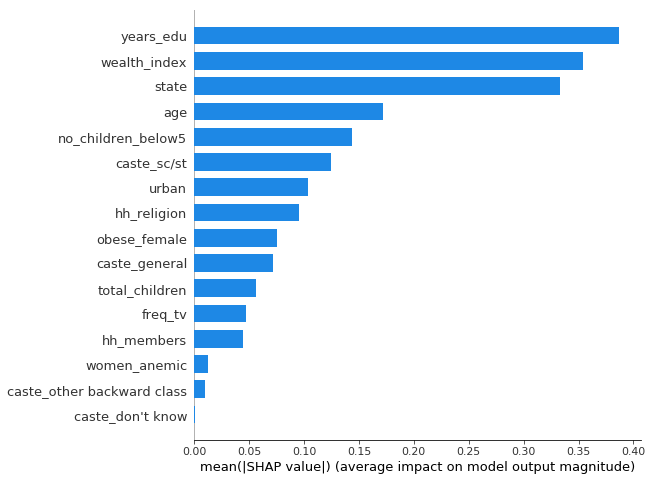

In [34]:
shap.summary_plot(shap_values, dataset, plot_type="bar")

The above figure shows the global mean(|Tree SHAP|) method applied to our model. 

**The x-axis is essentially the average magnitude change in model output when a feature is “hidden” from the model (for this model the output has log-odds units).** “Hidden” means integrating the variable out of the model. Since the impact of hiding a feature changes depending on what other features are also hidden, Shapley values are used to enforce consistency and accuracy.

However, since we now have individualized explanations for every person in our dataset, to get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low):

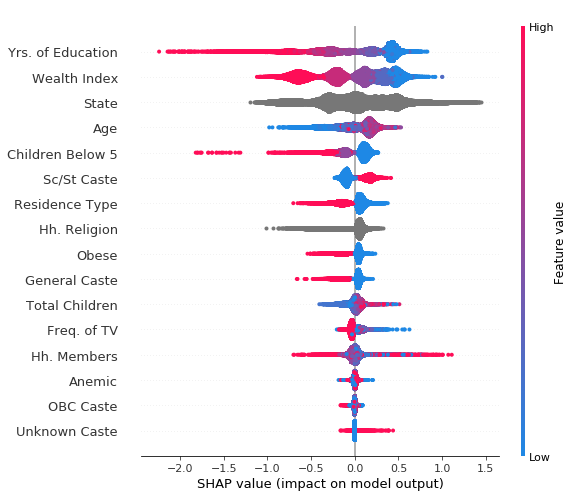

In [35]:
shap.summary_plot(shap_values, dataset_display)

- Every person has one dot on each row. 
- **The x position of the dot is the impact of that feature on the model’s prediction for the person.**
- **The color of the dot represents the value of that feature for the customer.** Categorical variables are colored grey.
- Dots that don’t fit on the row pile up to show density (since our dataset is large). 
- Since the XGBoost model has a logistic loss the x-axis has units of log-odds (Tree SHAP explains the change in the margin output of the model).

**How to use this**: We can make analysis similar to [the blog post](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27) for interpretting our models.

---

### SHAP Dependence Plots

Next, to understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. SHAP dependence plots show the effect of a single feature across the whole dataset. **They plot a feature's value vs. the SHAP value of that feature across many samples.** 

SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions. **One the benefits of SHAP dependence plots over traditional partial dependence plots is this ability to distigush between between models with and without interaction terms. In other words, SHAP dependence plots give an idea of the magnitude of the interaction terms through the vertical variance of the scatter plot at a given feature value.**

Good example of using Dependency Plots: https://slundberg.github.io/shap/notebooks/League%20of%20Legends%20Win%20Prediction%20with%20XGBoost.html

#### Plots for 'age'


Feature: age, Interaction Feature: age


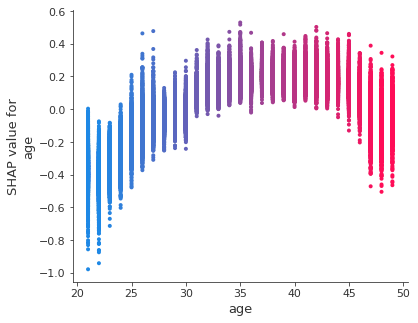


Feature: age, Interaction Feature: urban


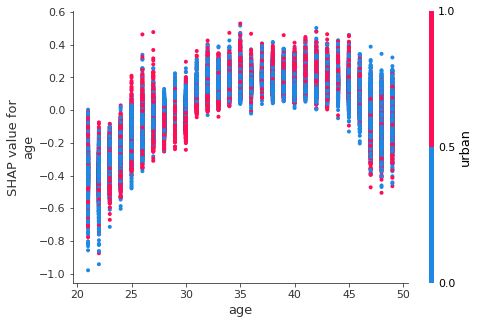


Feature: age, Interaction Feature: caste_sc/st


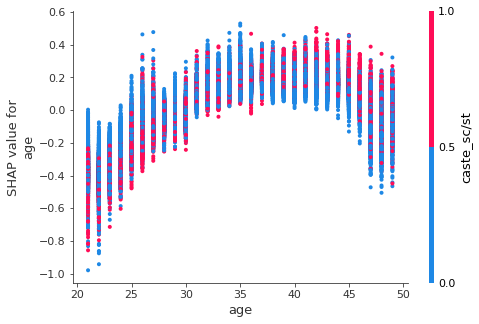


Feature: age, Interaction Feature: caste_general


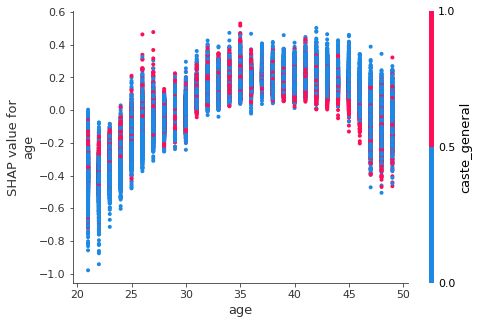


Feature: age, Interaction Feature: wealth_index


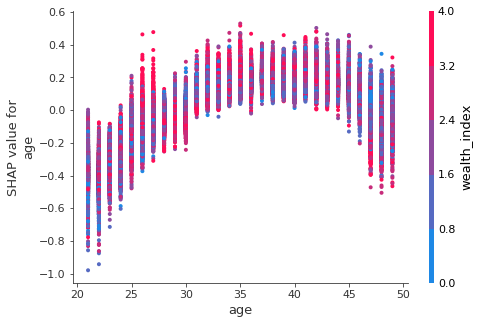


Feature: age, Interaction Feature: years_edu


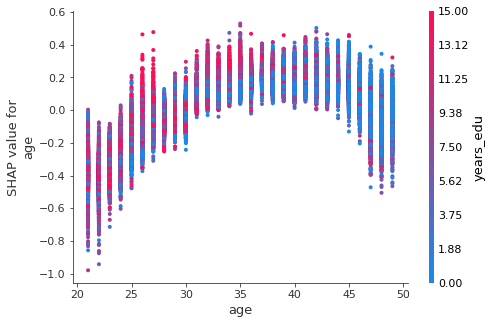


Feature: age, Interaction Feature: no_children_below5


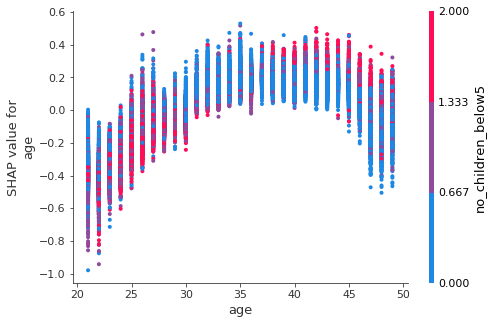


Feature: age, Interaction Feature: total_children


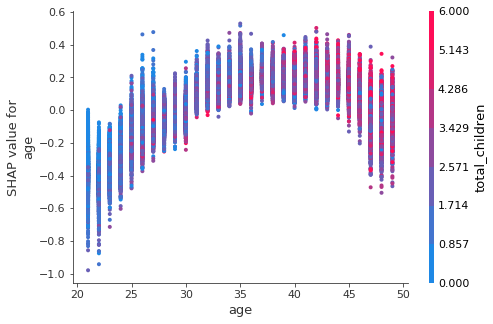


Feature: hh_religion, Interaction Feature: age


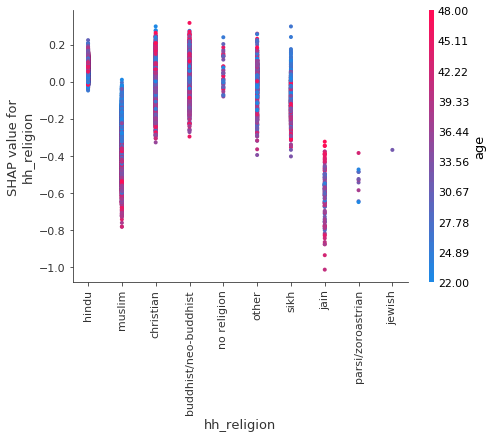


Feature: state, Interaction Feature: age


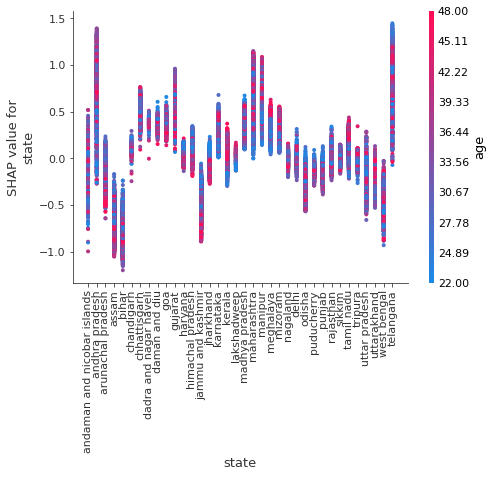

In [36]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('age', 'age'),
         ('age', 'urban'),
         ('age', 'caste_sc/st'),
         ('age', 'caste_general'),
         ('age', 'wealth_index'),
         ('age', 'years_edu'),
         ('age', 'no_children_below5'),
         ('age', 'total_children'),
         ('hh_religion', 'age'),
         ('state', 'age')]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(col_name, shap_values, dataset, display_features=dataset_display, interaction_index=int_col_name)

#### Plots for 'wealth_index'


Feature: wealth_index, Interaction Feature: wealth_index


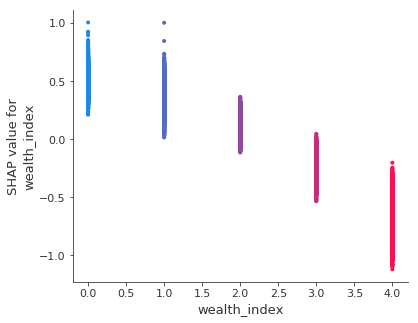


Feature: wealth_index, Interaction Feature: age


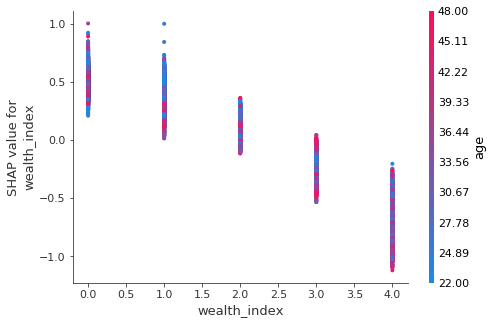


Feature: wealth_index, Interaction Feature: urban


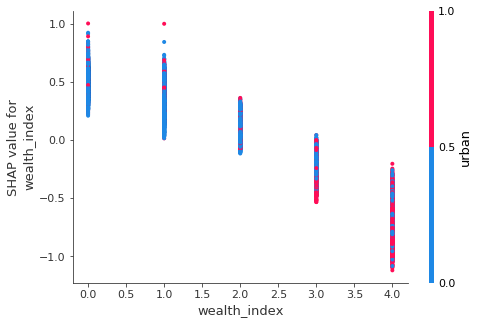


Feature: wealth_index, Interaction Feature: caste_sc/st


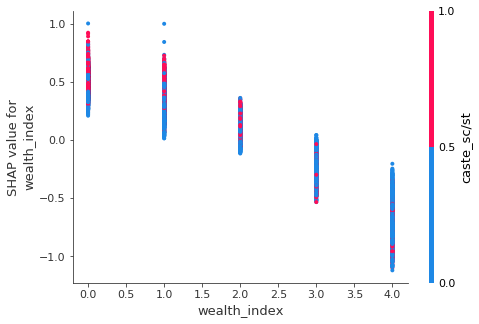


Feature: wealth_index, Interaction Feature: caste_general


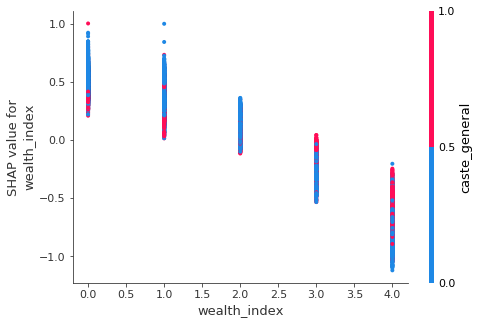


Feature: wealth_index, Interaction Feature: years_edu


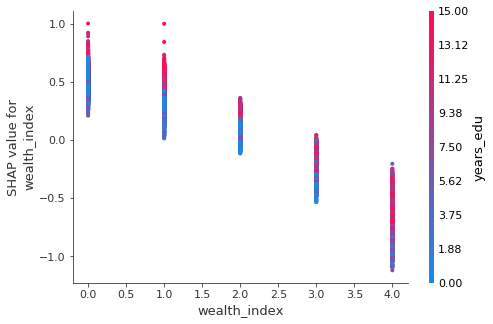


Feature: wealth_index, Interaction Feature: no_children_below5


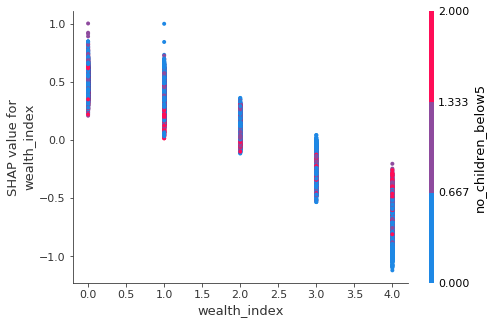


Feature: wealth_index, Interaction Feature: total_children


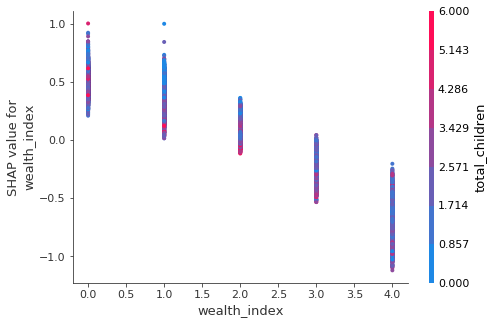


Feature: hh_religion, Interaction Feature: wealth_index


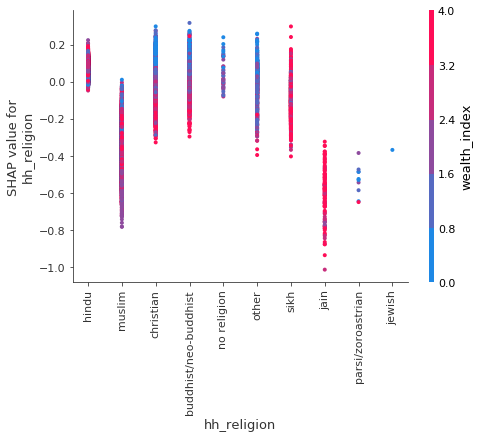


Feature: state, Interaction Feature: wealth_index


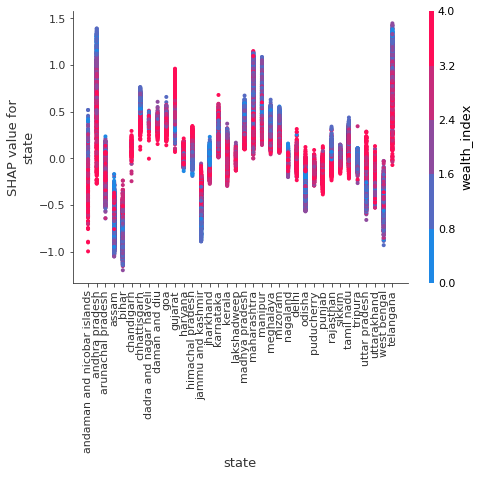

In [37]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('wealth_index', 'wealth_index'),
         ('wealth_index', 'age'), 
         ('wealth_index', 'urban'),
         ('wealth_index', 'caste_sc/st'),
         ('wealth_index', 'caste_general'),
         ('wealth_index', 'years_edu'),
         ('wealth_index', 'no_children_below5'),
         ('wealth_index', 'total_children'),
         ('hh_religion', 'wealth_index'),
         ('state', 'wealth_index')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(col_name, shap_values, dataset, display_features=dataset_display, interaction_index=int_col_name)

#### Plots for 'years_edu'


Feature: years_edu, Interaction Feature: years_edu


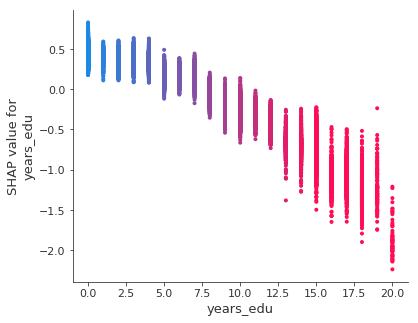


Feature: years_edu, Interaction Feature: age


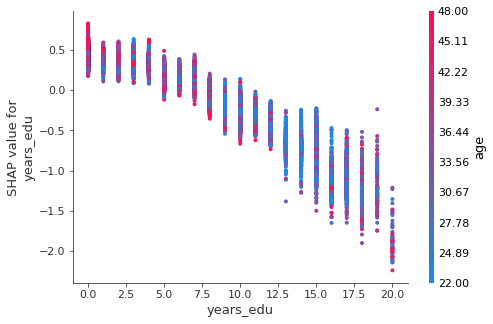


Feature: years_edu, Interaction Feature: urban


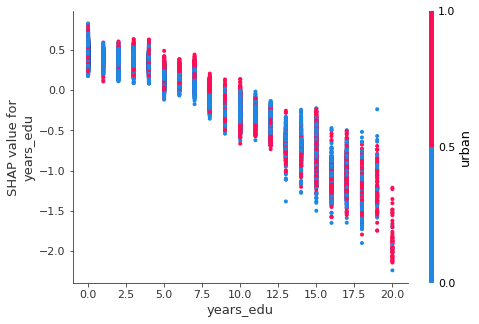


Feature: years_edu, Interaction Feature: caste_sc/st


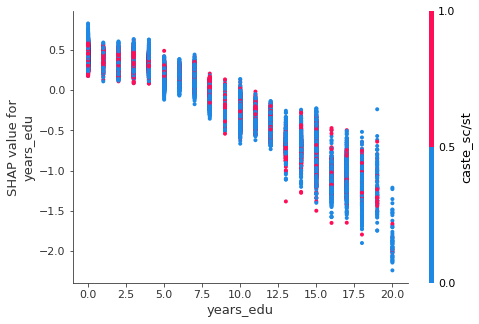


Feature: years_edu, Interaction Feature: caste_general


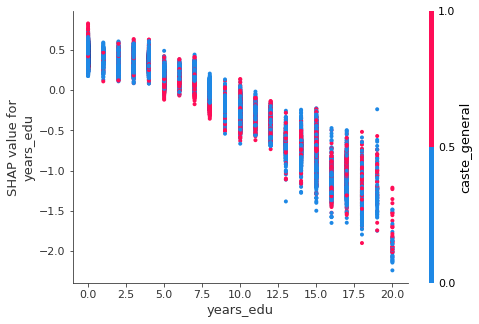


Feature: years_edu, Interaction Feature: wealth_index


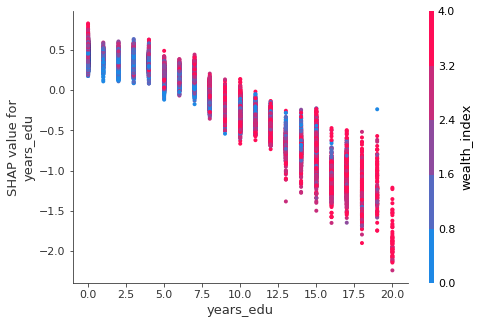


Feature: years_edu, Interaction Feature: no_children_below5


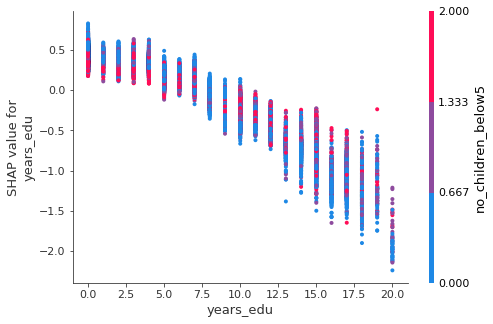


Feature: years_edu, Interaction Feature: total_children


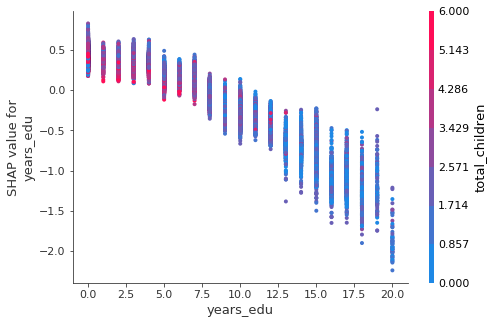


Feature: hh_religion, Interaction Feature: years_edu


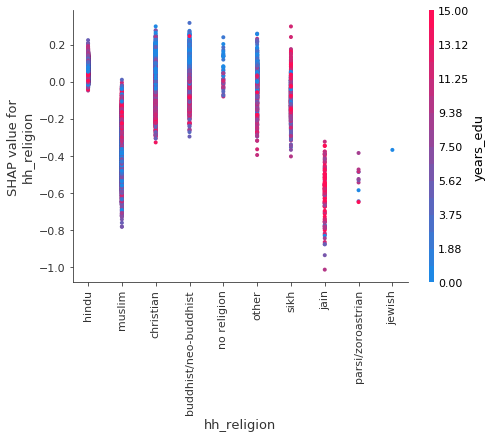


Feature: state, Interaction Feature: years_edu


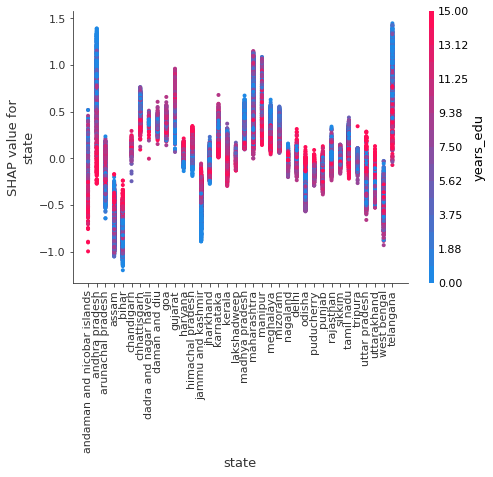

In [38]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('years_edu', 'years_edu'),
         ('years_edu', 'age'), 
         ('years_edu', 'urban'),
         ('years_edu', 'caste_sc/st'),
         ('years_edu', 'caste_general'),
         ('years_edu', 'wealth_index'),
         ('years_edu', 'no_children_below5'),
         ('years_edu', 'total_children'),
         ('hh_religion', 'years_edu'),
         ('state', 'years_edu')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(col_name, shap_values, dataset, display_features=dataset_display, interaction_index=int_col_name)

#### Plots for 'caste_sc/st'


Feature: caste_sc/st, Interaction Feature: caste_sc/st


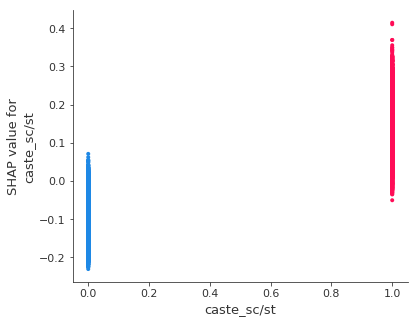


Feature: caste_sc/st, Interaction Feature: age


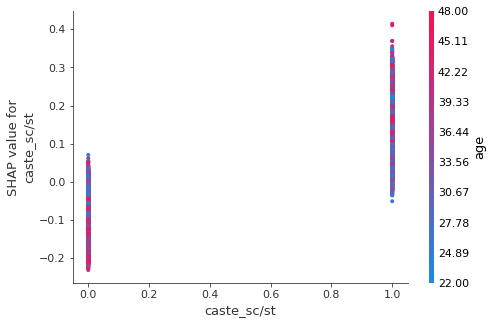


Feature: caste_sc/st, Interaction Feature: urban


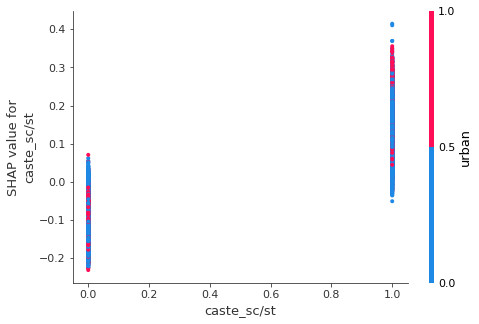


Feature: caste_sc/st, Interaction Feature: years_edu


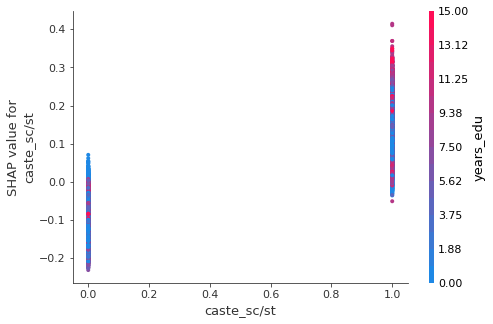


Feature: caste_sc/st, Interaction Feature: wealth_index


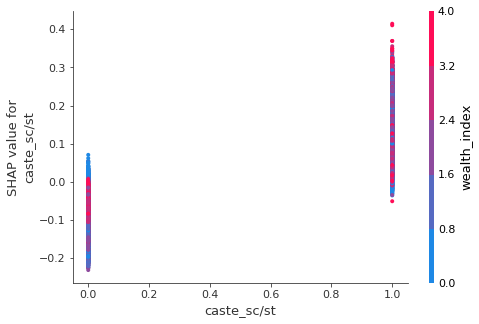


Feature: caste_sc/st, Interaction Feature: no_children_below5


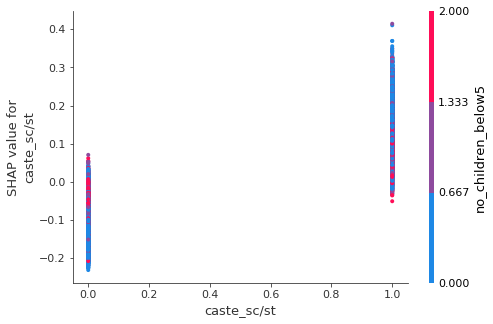


Feature: caste_sc/st, Interaction Feature: total_children


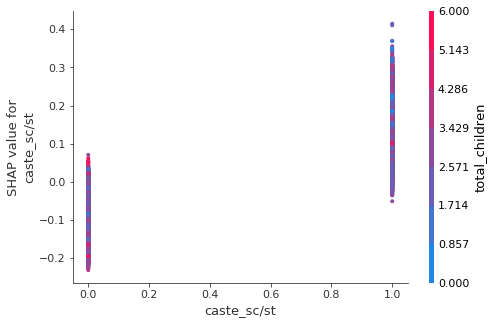


Feature: hh_religion, Interaction Feature: caste_sc/st


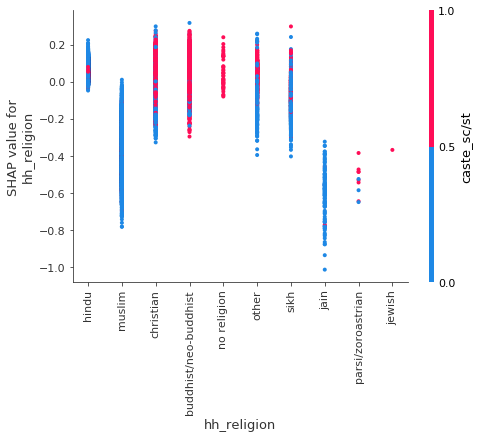


Feature: state, Interaction Feature: caste_sc/st


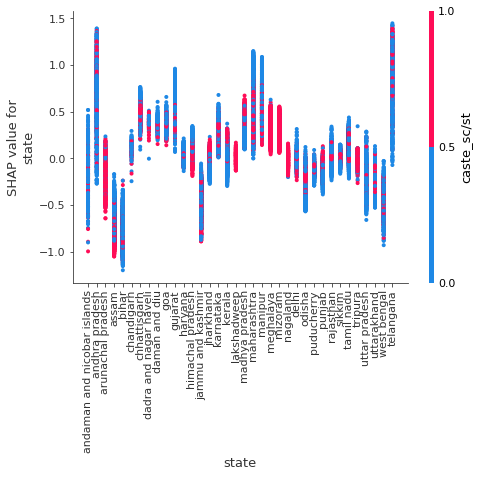

In [39]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('caste_sc/st', 'caste_sc/st'),
         ('caste_sc/st', 'age'), 
         ('caste_sc/st', 'urban'),
         ('caste_sc/st', 'years_edu'),
         ('caste_sc/st', 'wealth_index'),
         ('caste_sc/st', 'no_children_below5'),
         ('caste_sc/st', 'total_children'),
         ('hh_religion', 'caste_sc/st'),
         ('state', 'caste_sc/st')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(col_name, shap_values, dataset, display_features=dataset_display, interaction_index=int_col_name)

#### Plots for 'caste_general'


Feature: caste_general, Interaction Feature: caste_general


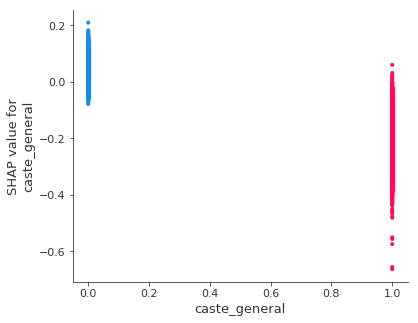


Feature: caste_general, Interaction Feature: age


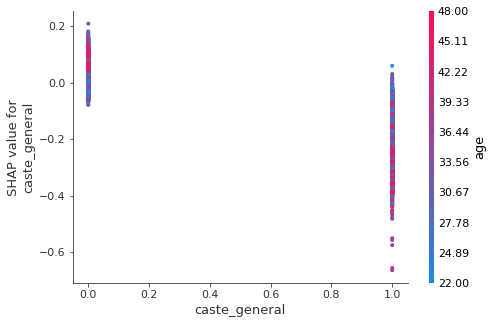


Feature: caste_general, Interaction Feature: urban


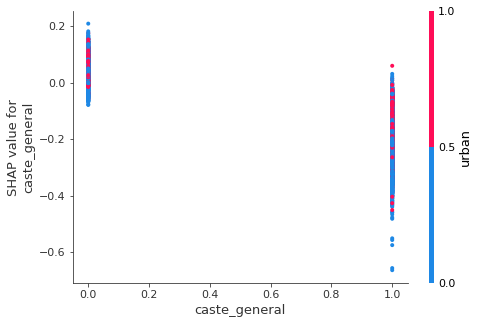


Feature: caste_general, Interaction Feature: years_edu


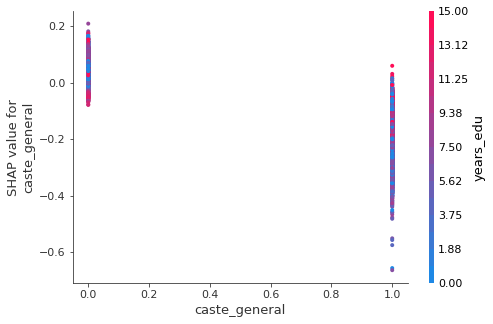


Feature: caste_general, Interaction Feature: wealth_index


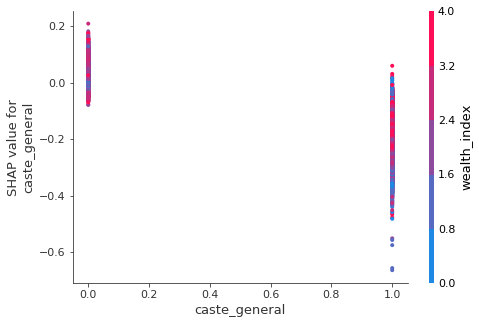


Feature: caste_general, Interaction Feature: no_children_below5


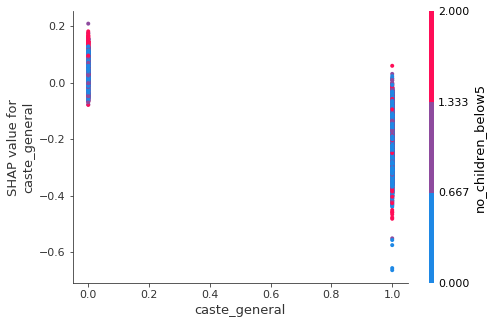


Feature: caste_general, Interaction Feature: total_children


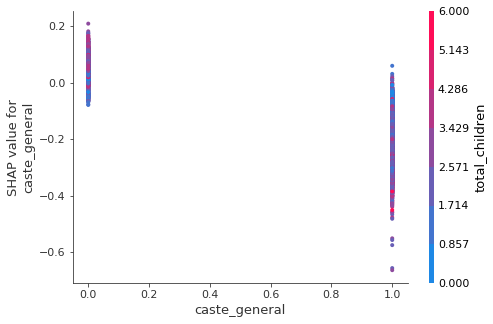


Feature: hh_religion, Interaction Feature: caste_general


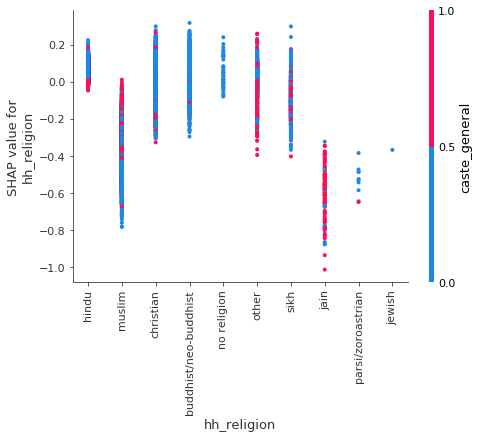


Feature: state, Interaction Feature: caste_general


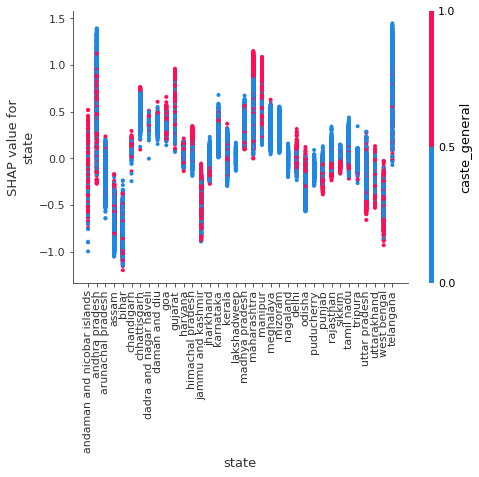

In [40]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('caste_general', 'caste_general'),
         ('caste_general', 'age'), 
         ('caste_general', 'urban'),
         ('caste_general', 'years_edu'),
         ('caste_general', 'wealth_index'),
         ('caste_general', 'no_children_below5'),
         ('caste_general', 'total_children'),
         ('hh_religion', 'caste_general'),
         ('state', 'caste_general')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(col_name, shap_values, dataset, display_features=dataset_display, interaction_index=int_col_name)

---

# Visualizing Bar/Summary plots split by age bins


Age Range: 21 - 25 years
Sample size: 14034

state - 0.3026053978829125
wealth_index - 0.3537775609239908
hh_religion - 0.07386638490990269
women_anemic - 0.01091456013302559
obese_female - 0.04798707420412837
urban - 0.10450015428732949
freq_tv - 0.05950145631349227
age - 0.2921491142483017
years_edu - 0.41488667575833266
hh_members - 0.04731932949195551
no_children_below5 - 0.17364774359826188
total_children - 0.0716685530182734
caste_don't know - 0.0010235193591526044
caste_general - 0.05749155550858089
caste_other backward class - 0.009293519675678298
caste_sc/st - 0.11425547358654378


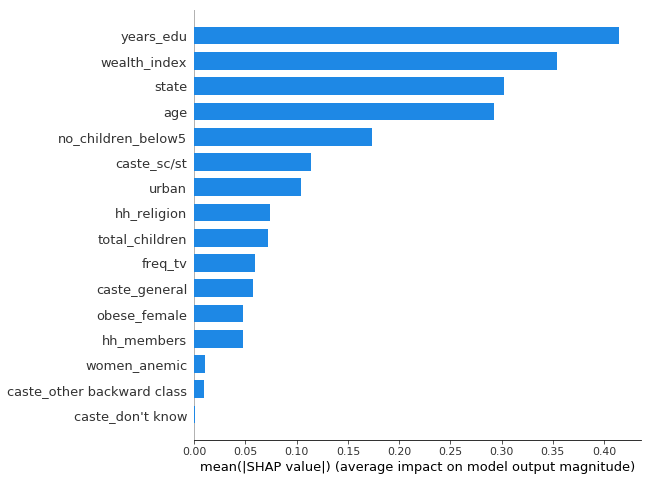

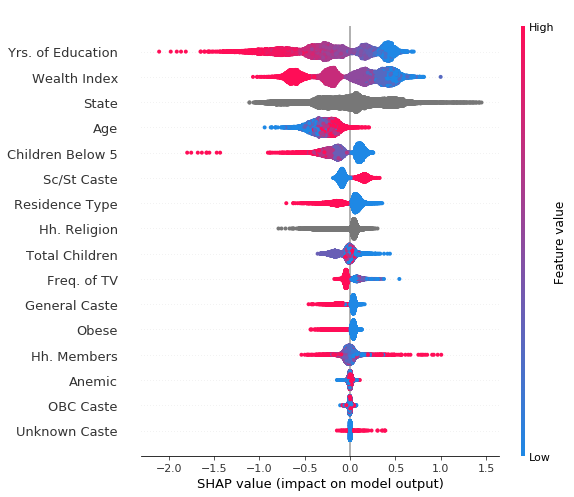


Age Range: 26 - 30 years
Sample size: 13706

state - 0.3301005487576073
wealth_index - 0.3559618625143623
hh_religion - 0.08843587123288825
women_anemic - 0.010553900073406603
obese_female - 0.06680178648320777
urban - 0.11841314205420557
freq_tv - 0.04509595589104865
age - 0.05241573640676622
years_edu - 0.3804742687473381
hh_members - 0.0483145100749847
no_children_below5 - 0.1813857076838349
total_children - 0.05395635534227774
caste_don't know - 0.0008964437195014538
caste_general - 0.0668907119811839
caste_other backward class - 0.010820102433579098
caste_sc/st - 0.11453339102193717


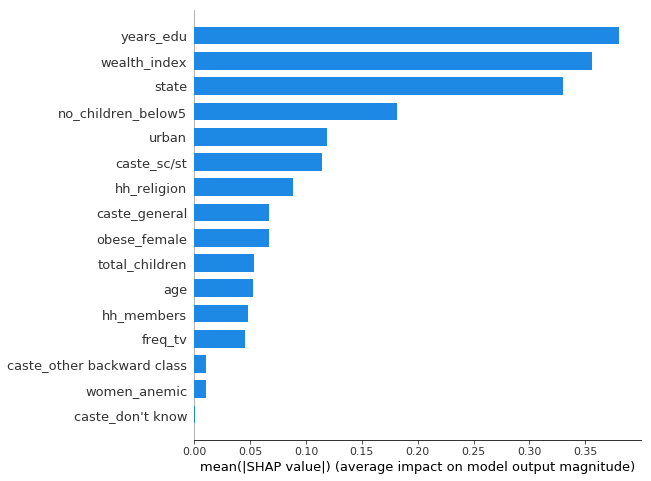

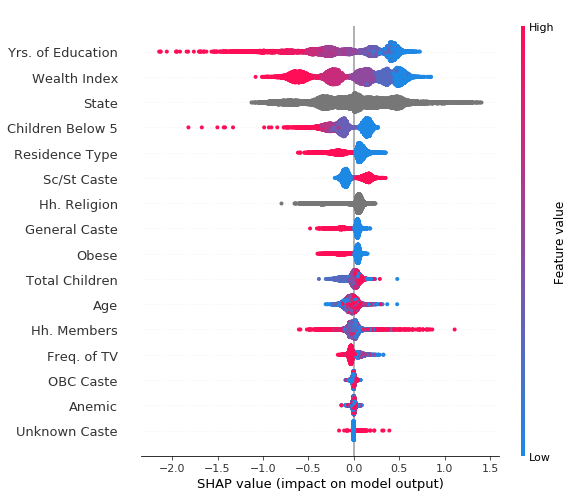


Age Range: 31 - 35 years
Sample size: 12526

state - 0.3495430766049304
wealth_index - 0.3446885510422806
hh_religion - 0.10910120861793177
women_anemic - 0.014695555729752053
obese_female - 0.0818960489283079
urban - 0.10491647564260433
freq_tv - 0.04264023802172609
age - 0.1632586271439636
years_edu - 0.36325943343832023
hh_members - 0.043088269198626634
no_children_below5 - 0.15763003437466738
total_children - 0.04810629541762849
caste_don't know - 0.0005482220241432459
caste_general - 0.07360421480461667
caste_other backward class - 0.010174978709587166
caste_sc/st - 0.12530036668076078


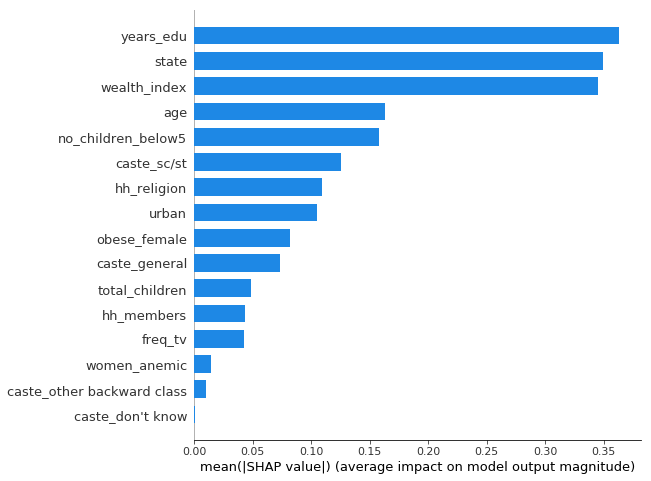

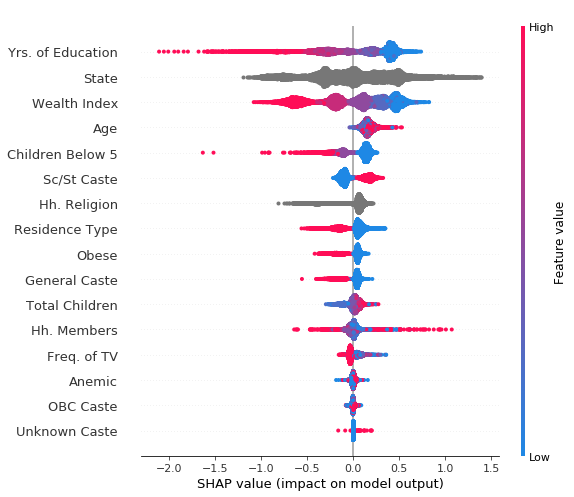


Age Range: 36 - 40 years
Sample size: 11283

state - 0.35533997395717315
wealth_index - 0.3515420946887581
hh_religion - 0.11159481736499423
women_anemic - 0.013685394306013272
obese_female - 0.08541778007955814
urban - 0.09559550153723782
freq_tv - 0.03963295076832347
age - 0.19353676067848535
years_edu - 0.3719416151959908
hh_members - 0.039788352967780535
no_children_below5 - 0.11050393541868181
total_children - 0.050371944714949594
caste_don't know - 0.0004529275029945085
caste_general - 0.07536526944052115
caste_other backward class - 0.010160717386944206
caste_sc/st - 0.13394603948676229


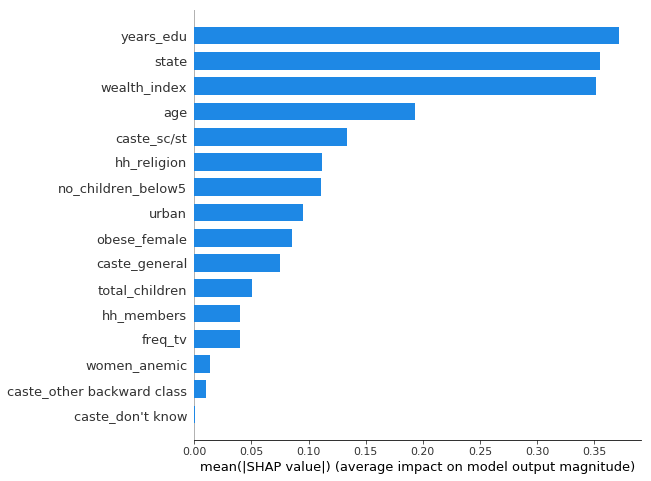

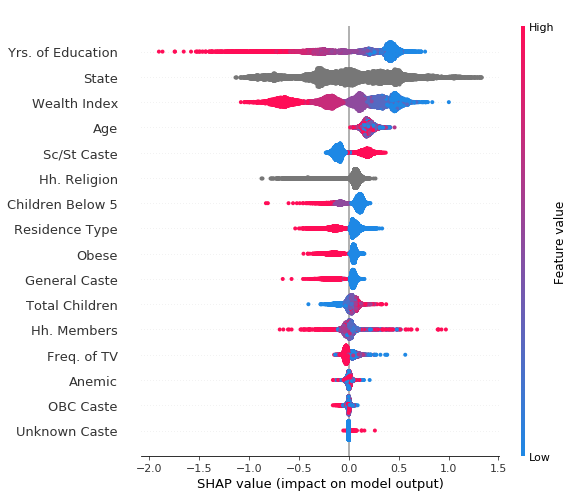


Age Range: 41 - 45 years
Sample size: 10087

state - 0.3461418985666017
wealth_index - 0.3602537679021365
hh_religion - 0.10573838525824424
women_anemic - 0.013157365871976082
obese_female - 0.09482486031549842
urban - 0.08944621807109131
freq_tv - 0.04299324056491018
age - 0.17777499975475158
years_edu - 0.38158619537433097
hh_members - 0.03934174547448142
no_children_below5 - 0.09625235503532308
total_children - 0.05481128314886503
caste_don't know - 0.00045174973389167924
caste_general - 0.08695508286191994
caste_other backward class - 0.009855056052289715
caste_sc/st - 0.13534962286887656


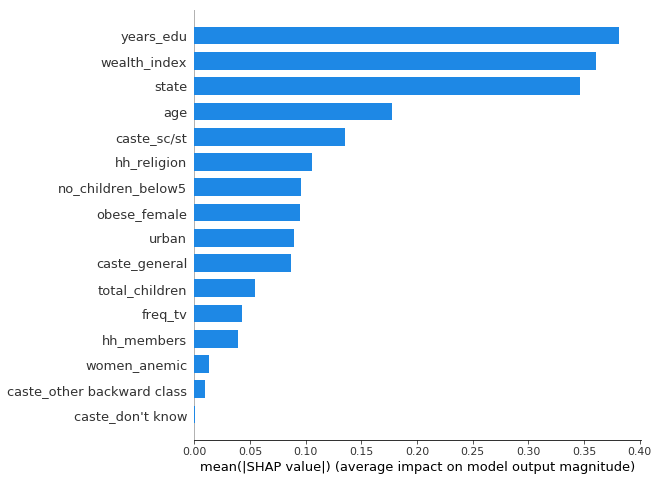

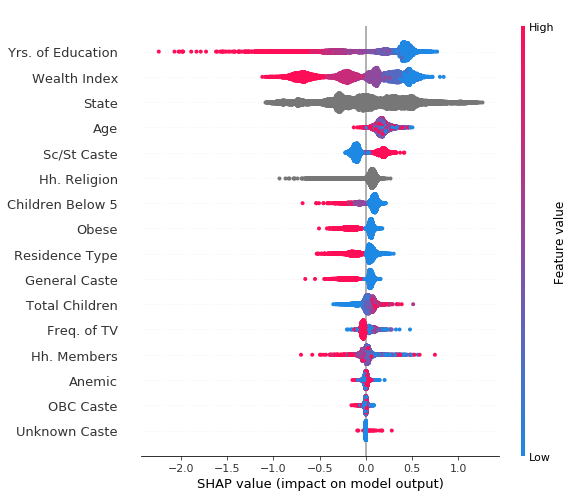


Age Range: 46 - 50 years
Sample size: 6013

state - 0.34287405764358186
wealth_index - 0.37567032942592365
hh_religion - 0.09396219614902841
women_anemic - 0.012471407232459696
obese_female - 0.09858026227732072
urban - 0.1045663101842607
freq_tv - 0.05046851249546494
age - 0.09521014695390322
years_edu - 0.4033645344310303
hh_members - 0.05136535071006243
no_children_below5 - 0.09934977543990349
total_children - 0.05099293413575399
caste_don't know - 0.000469501339851672
caste_general - 0.08300296169207906
caste_other backward class - 0.009493019576588923
caste_sc/st - 0.13663964760442418


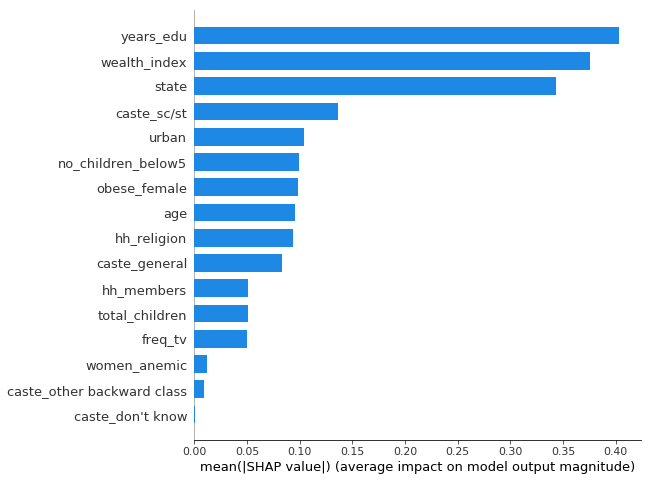

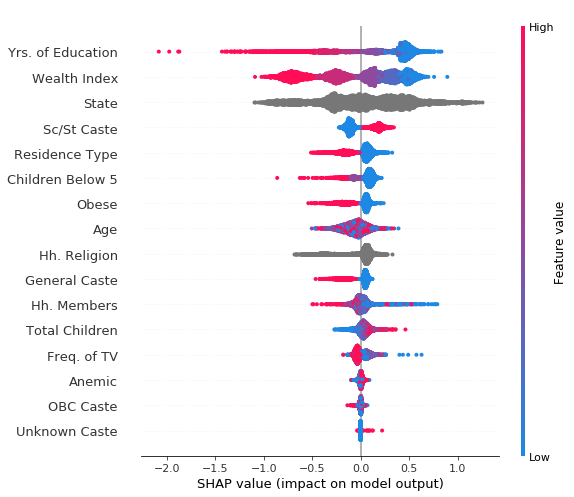

In [41]:
bins = [(21,25), (26,30), (31,35), (36,40), (41,45), (46,50)]

for low, high in bins:
    # Sample dataset by age range
    dataset_sample = dataset[(dataset.age > low) & (dataset.age <= high)]
    dataset_display_sample = dataset_display[(dataset.age > low) & (dataset.age <= high)]
    targets_sample = targets[(dataset.age > low) & (dataset.age <= high)]
    shap_values_sample = shap_values[(dataset.age > low) & (dataset.age <= high)]
    
    print("\nAge Range: {} - {} years".format(low, high))
    print("Sample size: {}\n".format(len(dataset_sample)))
    
    for col, sv in zip(dataset_sample.columns, np.abs(shap_values_sample).mean(0)):
        print(f"{col} - {sv}")
    
    # Summary plots
    shap.summary_plot(shap_values_sample, dataset_sample, plot_type="bar")
    shap.summary_plot(shap_values_sample, dataset_display_sample)

---

# Visualizing Bar/Summary plots split by State


State: andaman and nicobar islands
Sample size: 336

state - 0.22490275754093342
wealth_index - 0.39575774125202673
hh_religion - 0.07757549418878895
women_anemic - 0.02362187776372799
obese_female - 0.11075346759578485
urban - 0.13337419988662075
freq_tv - 0.026276728318785643
age - 0.23783092650146148
years_edu - 0.40752332487090515
hh_members - 0.03179592298679701
no_children_below5 - 0.12040504761818821
total_children - 0.051293784575944225
caste_don't know - 0.0009148721682236934
caste_general - 0.06826725758893178
caste_other backward class - 0.01288911212523291
caste_sc/st - 0.1661992858192614


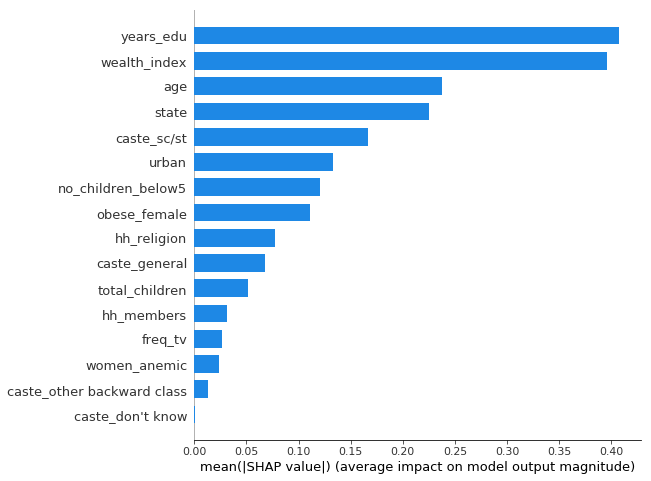

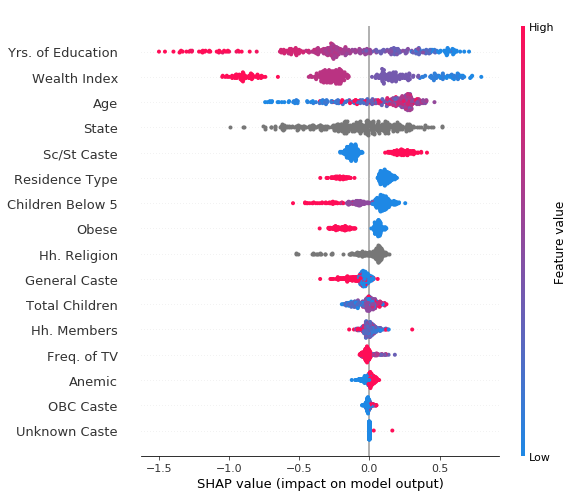


State: andhra pradesh
Sample size: 1239

state - 0.6995259531572144
wealth_index - 0.40387695617927655
hh_religion - 0.11110602353396906
women_anemic - 0.024559592934693734
obese_female - 0.11336077575678212
urban - 0.1593201251484165
freq_tv - 0.02914518953378186
age - 0.24596450488587257
years_edu - 0.5300662291174401
hh_members - 0.04017485700369268
no_children_below5 - 0.1310124999857883
total_children - 0.044243998020863894
caste_don't know - 0.0011159230672847596
caste_general - 0.09535908519172895
caste_other backward class - 0.0107268976182797
caste_sc/st - 0.12047984210125565


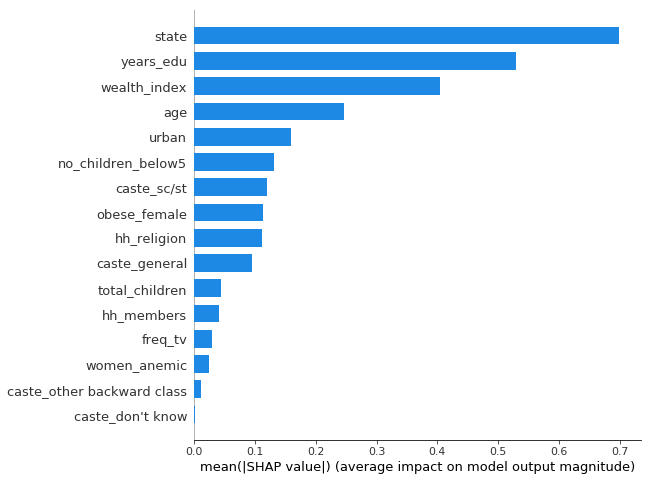

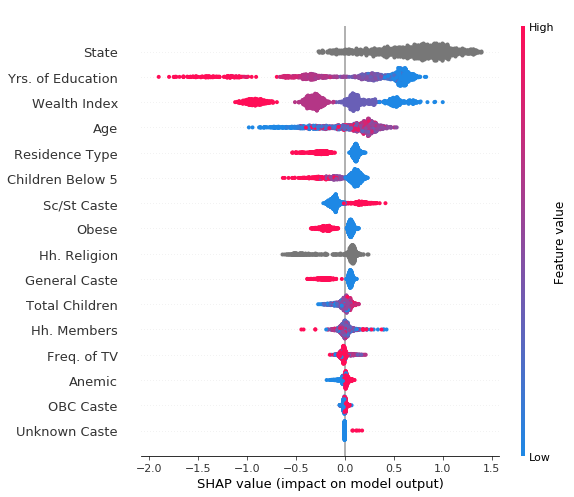


State: arunachal pradesh
Sample size: 1662

state - 0.18950672545937775
wealth_index - 0.30359383821366526
hh_religion - 0.07309322571396783
women_anemic - 0.015000530056877459
obese_female - 0.08645171234833944
urban - 0.10976633292205244
freq_tv - 0.05124086709632671
age - 0.16828760374970267
years_edu - 0.3514103434738965
hh_members - 0.04006524438402856
no_children_below5 - 0.09517481403527155
total_children - 0.05385993172400847
caste_don't know - 0.0007699892345826218
caste_general - 0.05328564729864055
caste_other backward class - 0.004510520261934794
caste_sc/st - 0.11941187404867566


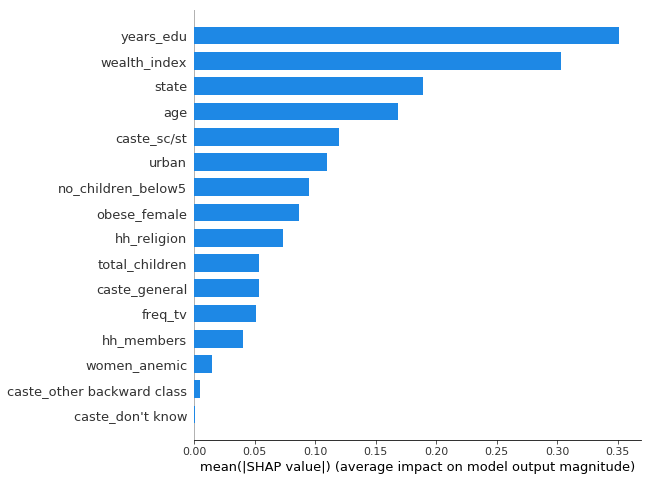

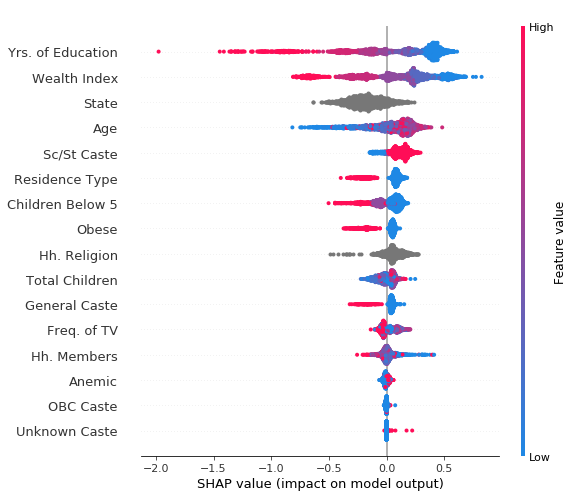


State: assam
Sample size: 2858

state - 0.6767193021341475
wealth_index - 0.297174537770023
hh_religion - 0.07889846457617704
women_anemic - 0.008172537337915745
obese_female - 0.07007678914650702
urban - 0.05074098065815295
freq_tv - 0.04563202068208622
age - 0.15188191091263095
years_edu - 0.3574798790843523
hh_members - 0.0331469513835127
no_children_below5 - 0.12501998740712497
total_children - 0.054896487370942694
caste_don't know - 0.0014830702612269047
caste_general - 0.06736415080472354
caste_other backward class - 0.009513889864403234
caste_sc/st - 0.07012700392624328


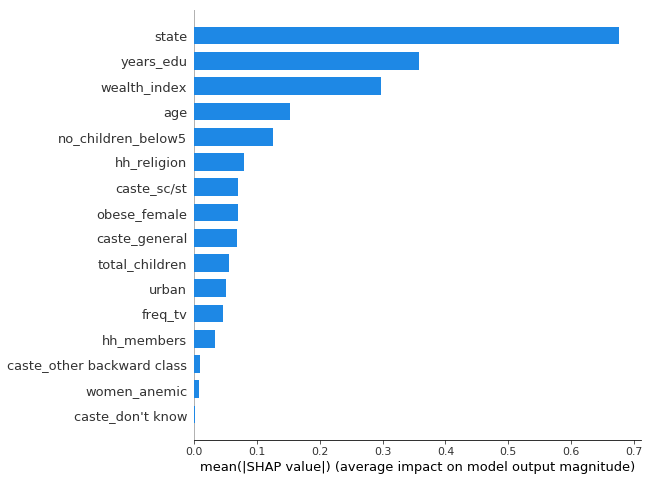

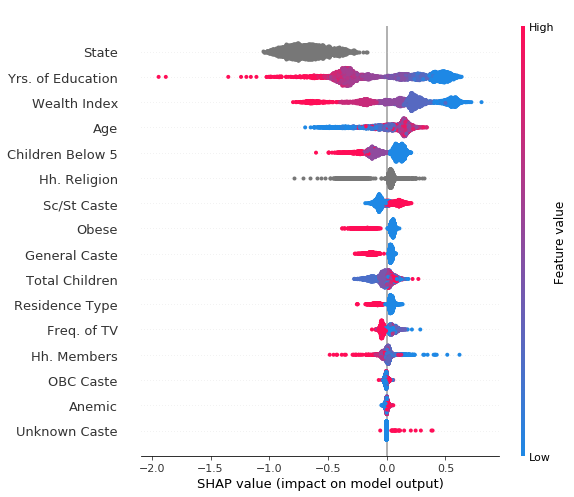


State: bihar
Sample size: 4860

state - 0.7872337203193099
wealth_index - 0.3365686895650104
hh_religion - 0.07116742741560492
women_anemic - 0.0072752608109284385
obese_female - 0.06723710528390757
urban - 0.05279894453354658
freq_tv - 0.04641503385459428
age - 0.16220029665277516
years_edu - 0.3405805522851983
hh_members - 0.05042376912366137
no_children_below5 - 0.1558642218415927
total_children - 0.06048400425286867
caste_don't know - 0.0006034408694786792
caste_general - 0.07614019445884485
caste_other backward class - 0.012042183105923152
caste_sc/st - 0.13995352449134565


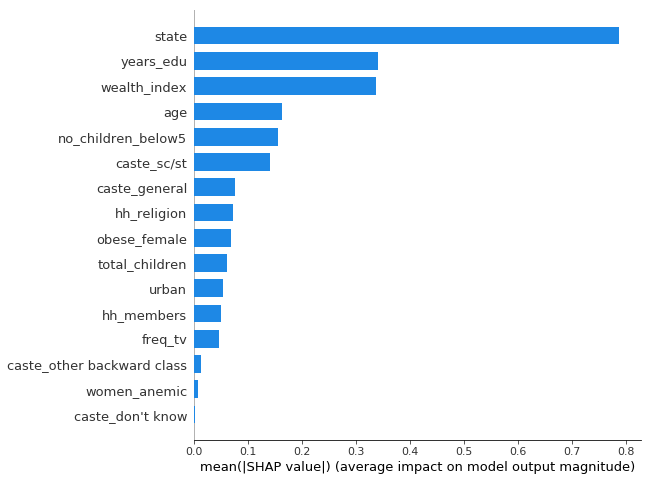

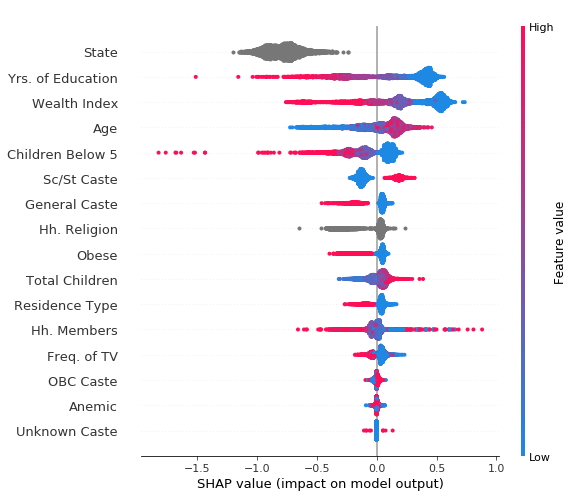


State: chandigarh
Sample size: 87

state - 0.11583611606982393
wealth_index - 0.5465601660569787
hh_religion - 0.09925947051911937
women_anemic - 0.016570855509922322
obese_female - 0.08207972349800914
urban - 0.1108489446787766
freq_tv - 0.05227752742996181
age - 0.17748040866835962
years_edu - 0.45499175001061937
hh_members - 0.03481460862311774
no_children_below5 - 0.09318486273978968
total_children - 0.04346081177480677
caste_don't know - 0.0004555383663792147
caste_general - 0.07319365479704776
caste_other backward class - 0.008595398964610302
caste_sc/st - 0.10337116421041861


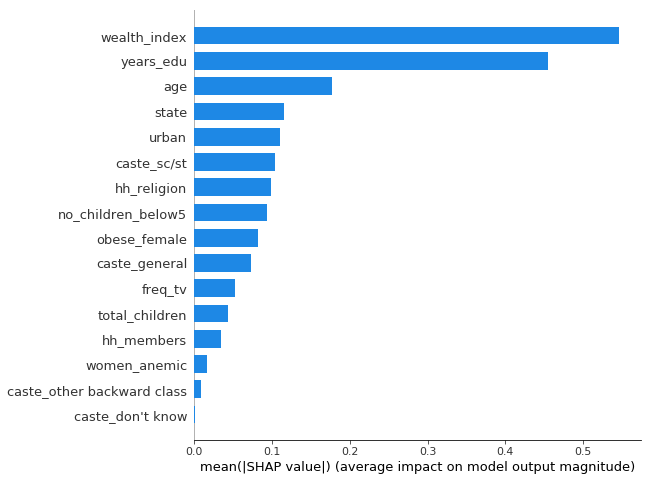

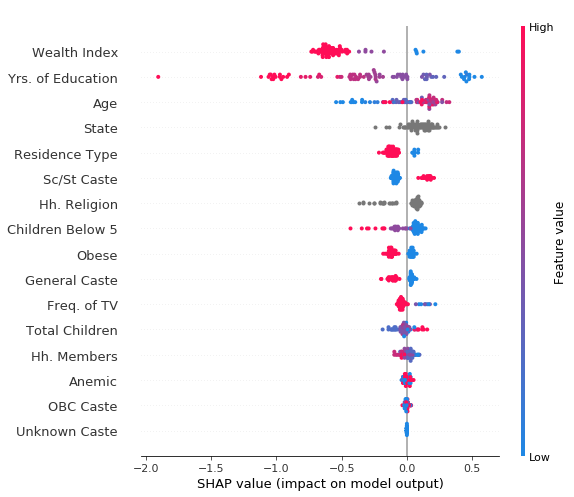


State: chhattisgarh
Sample size: 2836

state - 0.5314364229054513
wealth_index - 0.4113309509060034
hh_religion - 0.08062690858343098
women_anemic - 0.01488808749729402
obese_female - 0.07078932573738089
urban - 0.10922077074212891
freq_tv - 0.058536348563784917
age - 0.17604630708521285
years_edu - 0.3705646872594315
hh_members - 0.03229909364080063
no_children_below5 - 0.14813990741814306
total_children - 0.054428679109865145
caste_don't know - 0.0005171549765623878
caste_general - 0.046896652248353946
caste_other backward class - 0.00527104966189413
caste_sc/st - 0.08458134617638531


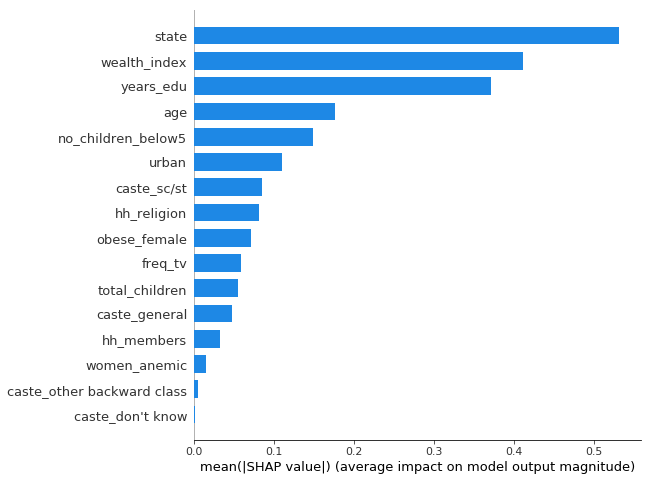

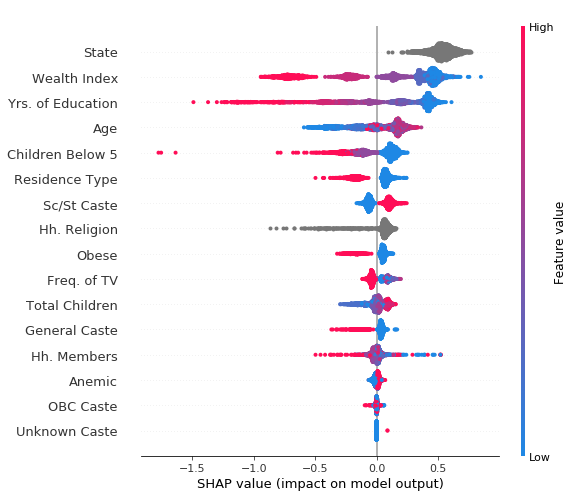


State: dadra and nagar haveli
Sample size: 118

state - 0.3799751102266695
wealth_index - 0.3911791595475753
hh_religion - 0.07193083962628795
women_anemic - 0.01566761164726904
obese_female - 0.07056918529927915
urban - 0.11301043709687927
freq_tv - 0.06202707183905362
age - 0.1670131168571231
years_edu - 0.39522464060162105
hh_members - 0.035903028750475595
no_children_below5 - 0.162597629864105
total_children - 0.050268590703452944
caste_don't know - 0.001764595196147212
caste_general - 0.051074022199093946
caste_other backward class - 0.004385366922826484
caste_sc/st - 0.1114169989696402


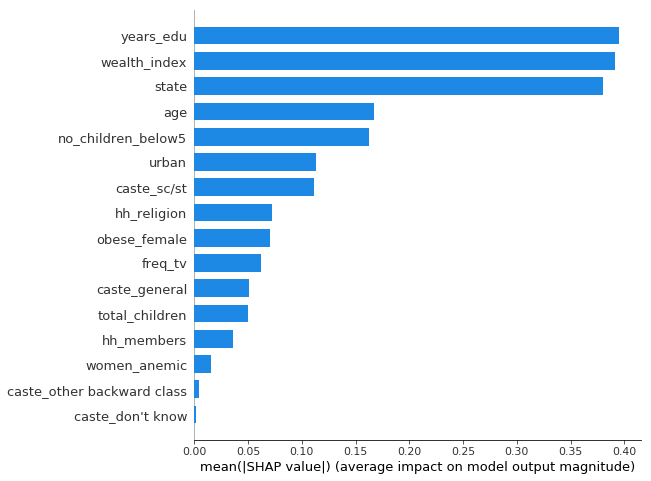

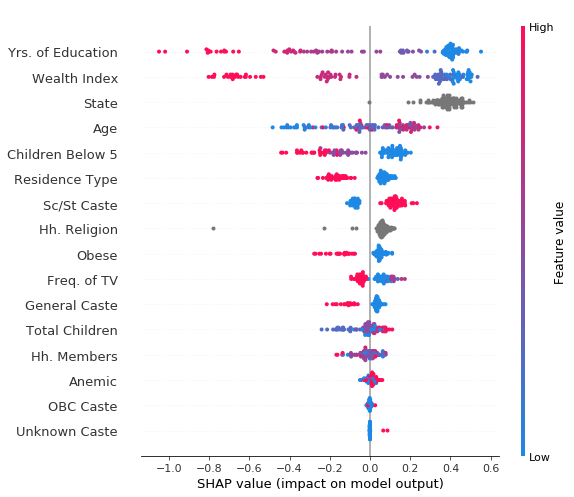


State: daman and diu
Sample size: 252

state - 0.36600441454731325
wealth_index - 0.40650672990656683
hh_religion - 0.10275136180158975
women_anemic - 0.015604196836224077
obese_female - 0.09035146897429883
urban - 0.13894942372858565
freq_tv - 0.04784001971141048
age - 0.1827348971013506
years_edu - 0.35477852002839294
hh_members - 0.04850970011924256
no_children_below5 - 0.13325160951218434
total_children - 0.05262492061783281
caste_don't know - 0.005399905958038166
caste_general - 0.05002729977148722
caste_other backward class - 0.007767148486956291
caste_sc/st - 0.08011938029746798


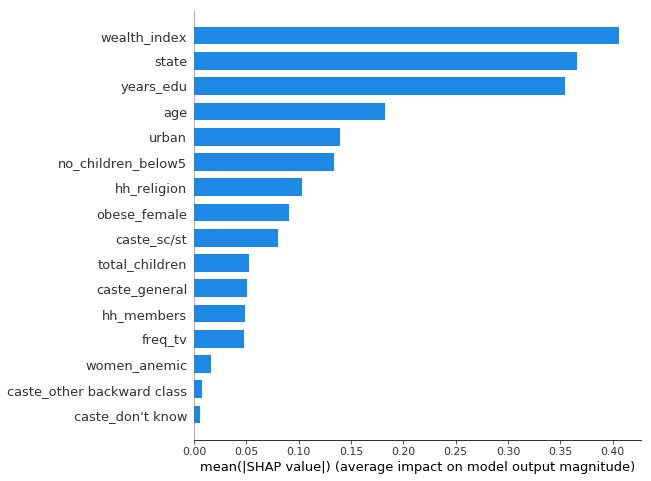

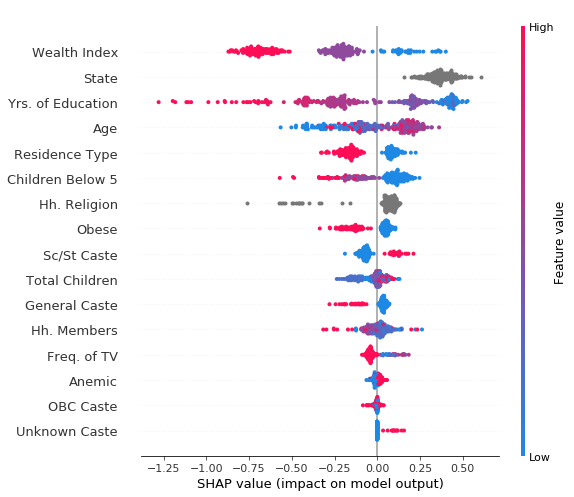


State: goa
Sample size: 567

state - 0.3686560606681189
wealth_index - 0.4632420890314901
hh_religion - 0.10325264454562282
women_anemic - 0.016078657640798102
obese_female - 0.09125226276837077
urban - 0.12611830182386566
freq_tv - 0.05136149113055728
age - 0.16246569919239484
years_edu - 0.40990841601121736
hh_members - 0.04350506187273075
no_children_below5 - 0.11273364185263281
total_children - 0.05212363845307391
caste_don't know - 0.0005884170888291093
caste_general - 0.07714277212315772
caste_other backward class - 0.0075816929485422
caste_sc/st - 0.08695691899088423


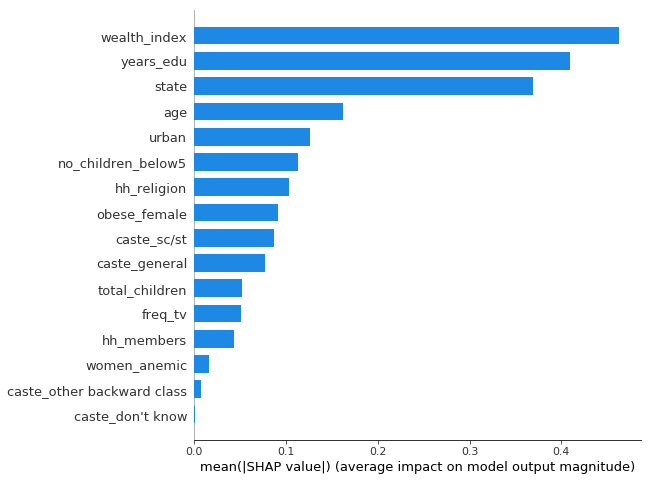

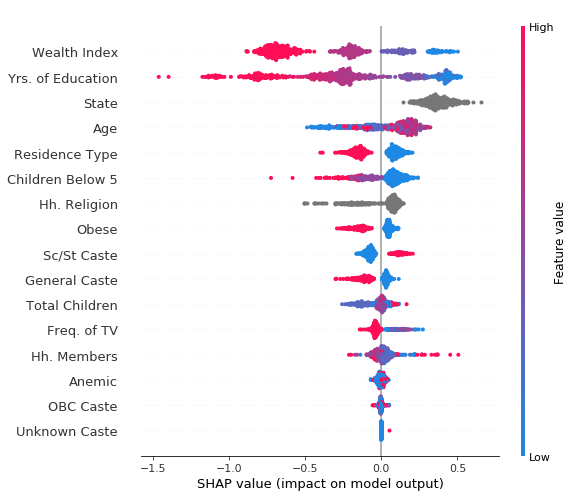


State: gujarat
Sample size: 4197

state - 0.48851463416126084
wealth_index - 0.31448397968952646
hh_religion - 0.10757044001502669
women_anemic - 0.015163237063833898
obese_female - 0.07154426543960053
urban - 0.10582619943132512
freq_tv - 0.058095241797418304
age - 0.19069351211176347
years_edu - 0.3536723062020837
hh_members - 0.03713420530241682
no_children_below5 - 0.15697234687172396
total_children - 0.04948814287252617
caste_don't know - 0.0017739012454468937
caste_general - 0.059265202187589495
caste_other backward class - 0.006121901765366089
caste_sc/st - 0.09566198057799255


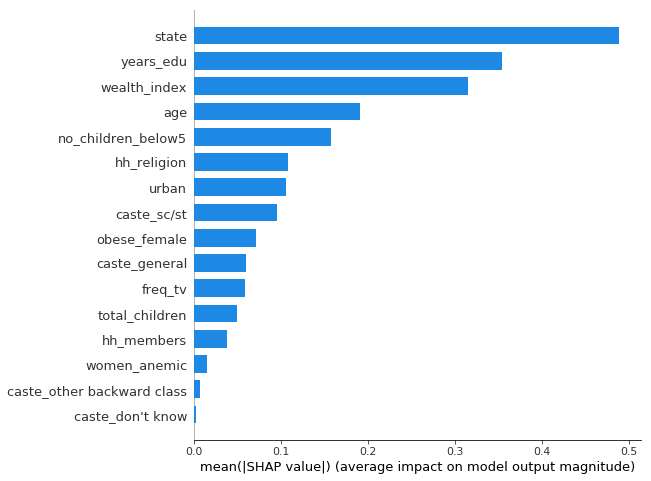

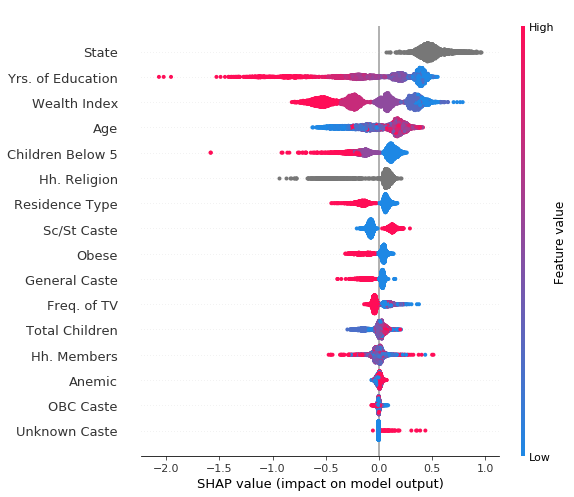


State: haryana
Sample size: 2415

state - 0.047949742541488774
wealth_index - 0.43580775965519036
hh_religion - 0.09170874654140511
women_anemic - 0.011507221119015
obese_female - 0.0555796994879415
urban - 0.11911691510969735
freq_tv - 0.038820781619426446
age - 0.16619466116971487
years_edu - 0.3952171998400796
hh_members - 0.03449610057239232
no_children_below5 - 0.11775677406182568
total_children - 0.04483230381063701
caste_don't know - 0.0004912153051197719
caste_general - 0.06751466122568545
caste_other backward class - 0.006602567558365476
caste_sc/st - 0.10034035343714567


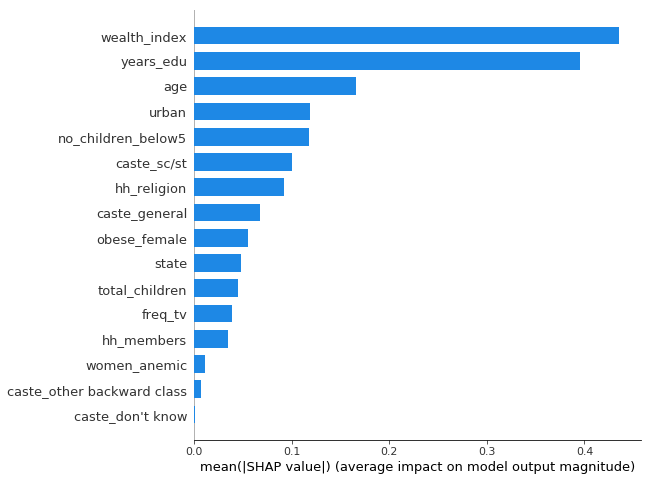

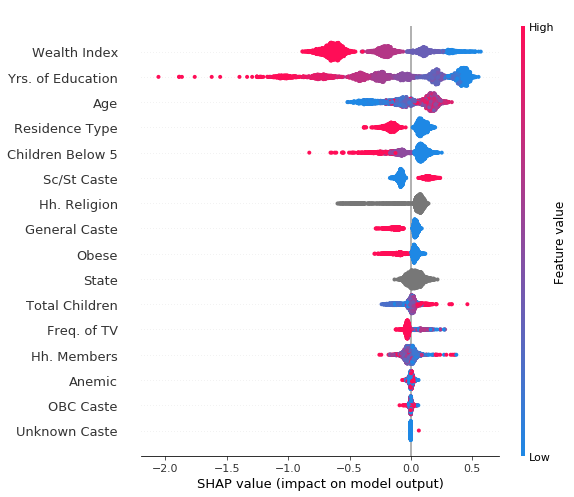


State: himachal pradesh
Sample size: 2193

state - 0.1388247194199988
wealth_index - 0.295646629163102
hh_religion - 0.07538536751380254
women_anemic - 0.011810908675817685
obese_female - 0.06828140670002952
urban - 0.09335670723811451
freq_tv - 0.03692979850482259
age - 0.15672413737197033
years_edu - 0.3906692774824971
hh_members - 0.030426336862942622
no_children_below5 - 0.11478765535682041
total_children - 0.04103896271651636
caste_don't know - 0.0008473871610681455
caste_general - 0.09006855384276852
caste_other backward class - 0.007053030249407159
caste_sc/st - 0.11524363501507345


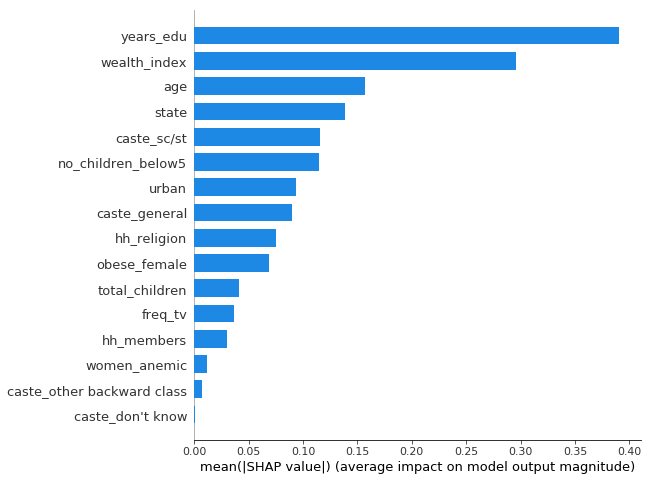

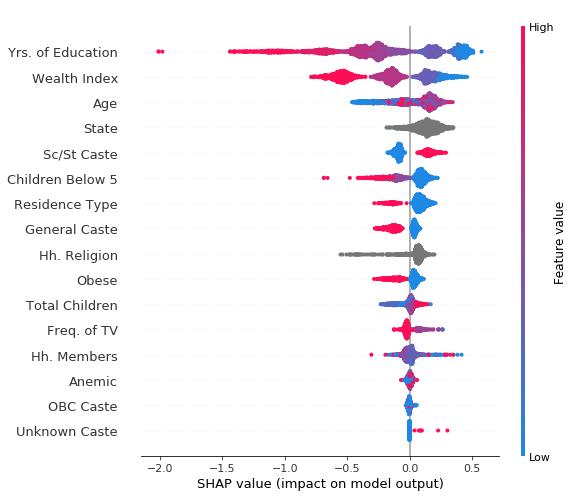


State: jammu and kashmir
Sample size: 2889

state - 0.46221688284631773
wealth_index - 0.29878317907288265
hh_religion - 0.1854807527580972
women_anemic - 0.010403897880287127
obese_female - 0.061885329599606485
urban - 0.05470380193287553
freq_tv - 0.03477683882079221
age - 0.12510373416189208
years_edu - 0.2876798034236053
hh_members - 0.03590788792162729
no_children_below5 - 0.11554542807768894
total_children - 0.03969090203453901
caste_don't know - 0.0010145769439508414
caste_general - 0.0957281174593996
caste_other backward class - 0.009912594707162901
caste_sc/st - 0.12400398812262077


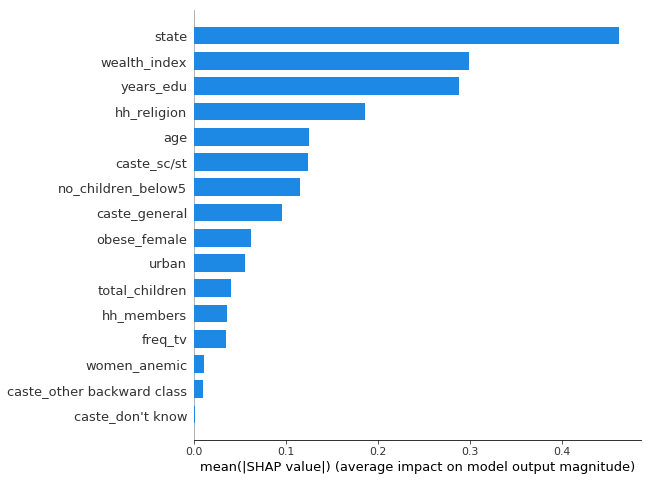

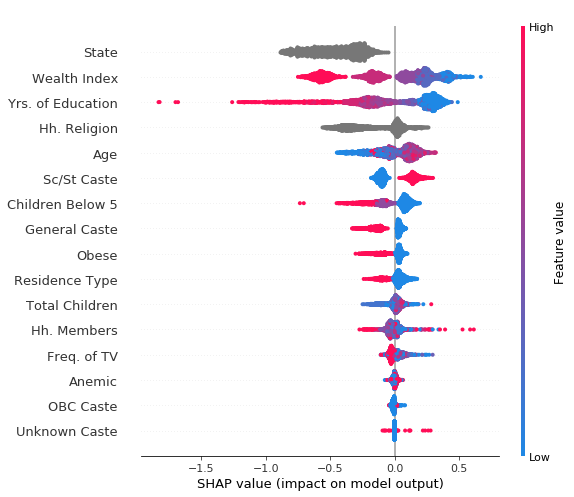


State: jharkhand
Sample size: 3171

state - 0.06297091389338677
wealth_index - 0.423902651285752
hh_religion - 0.09380387314344511
women_anemic - 0.009173331036121758
obese_female - 0.05382483617719687
urban - 0.09644277534709927
freq_tv - 0.04604112904775316
age - 0.1556005026297
years_edu - 0.38438869243106005
hh_members - 0.03501022934278443
no_children_below5 - 0.13377600894059669
total_children - 0.0497068317983828
caste_don't know - 0.0004757900646913099
caste_general - 0.06575919599443927
caste_other backward class - 0.0064950043099479965
caste_sc/st - 0.1561450150611741


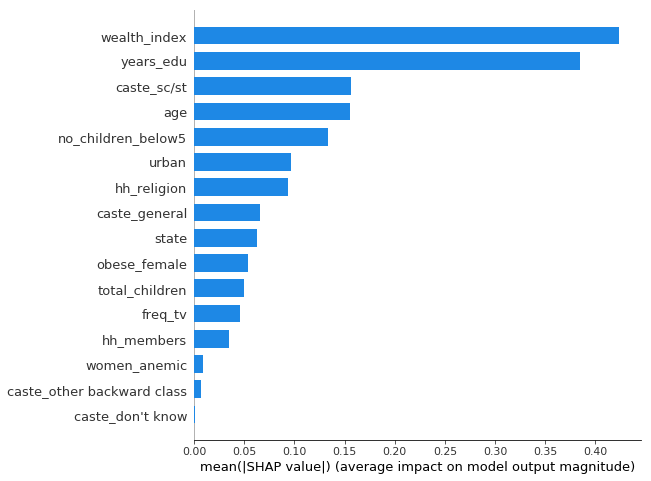

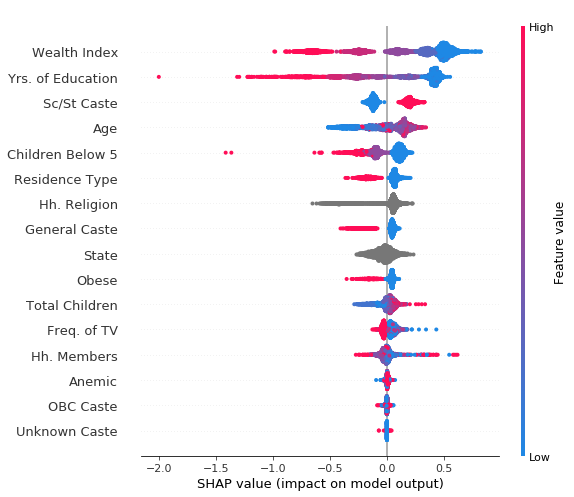


State: karnataka
Sample size: 2920

state - 0.28975848157486045
wealth_index - 0.30498921894582776
hh_religion - 0.10499294399318483
women_anemic - 0.011634433303321642
obese_female - 0.08248166163176723
urban - 0.07237477968992309
freq_tv - 0.043196432209003696
age - 0.18135795221559997
years_edu - 0.3802122881204153
hh_members - 0.04425800874305073
no_children_below5 - 0.1487450265354114
total_children - 0.055206852009221416
caste_don't know - 0.0011881394574205068
caste_general - 0.0503582921023233
caste_other backward class - 0.007969852267552407
caste_sc/st - 0.1069288050437934


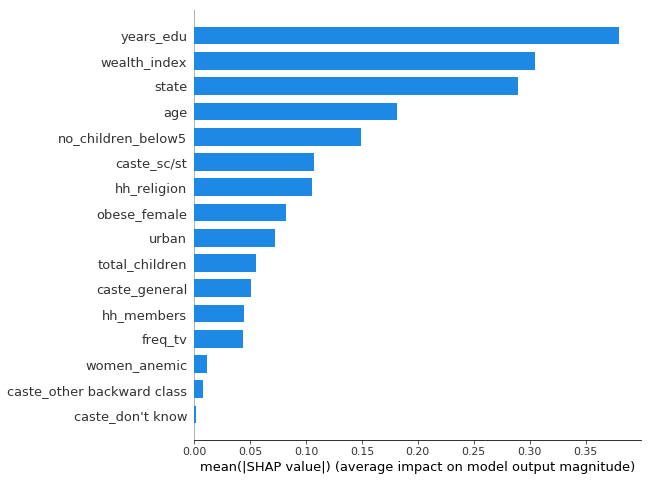

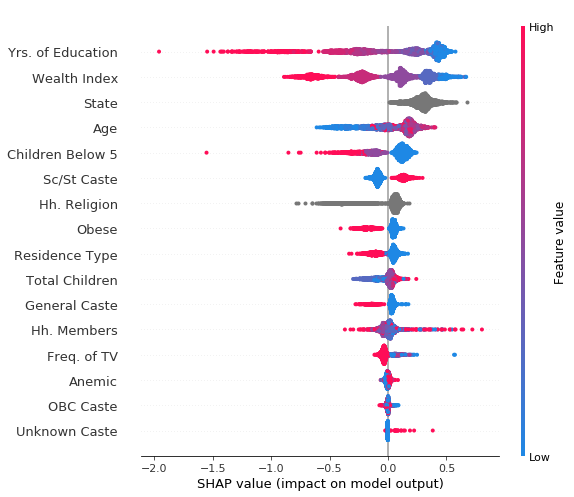


State: kerala
Sample size: 1761

state - 0.09691250090291197
wealth_index - 0.41955107410916126
hh_religion - 0.19454768260688146
women_anemic - 0.014650388454981705
obese_female - 0.06654744702318252
urban - 0.08678421826821879
freq_tv - 0.04347102069174351
age - 0.1704404719135908
years_edu - 0.5186432782264728
hh_members - 0.040017007396101104
no_children_below5 - 0.11936941194836387
total_children - 0.04326038446884112
caste_don't know - 0.0006417959042146334
caste_general - 0.06600382152512504
caste_other backward class - 0.008426692101614393
caste_sc/st - 0.12661800751646515


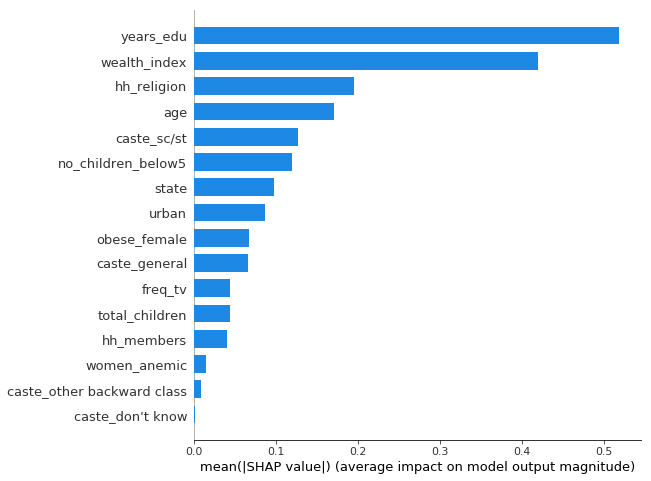

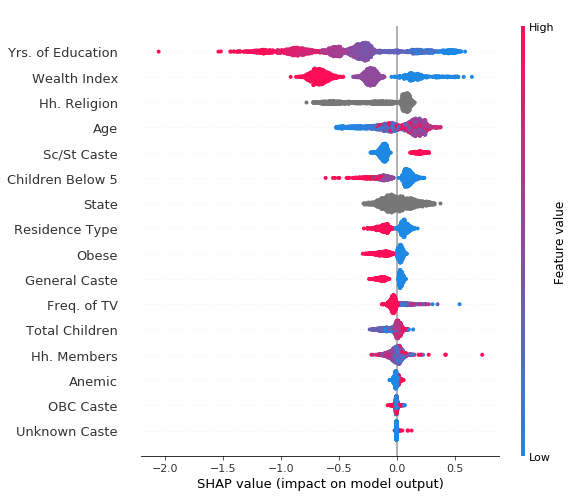


State: lakshadweep
Sample size: 165

state - 0.06018859500279017
wealth_index - 0.4938053822731417
hh_religion - 0.4201872223875007
women_anemic - 0.021899724751646043
obese_female - 0.09061447095841847
urban - 0.10282524414244952
freq_tv - 0.051058723029729754
age - 0.17282227008781448
years_edu - 0.38838632196244566
hh_members - 0.053360256850856214
no_children_below5 - 0.13393480524550805
total_children - 0.044569317766170145
caste_don't know - 0.00021237591889915745
caste_general - 0.03357426976118198
caste_other backward class - 0.00873755619414861
caste_sc/st - 0.20338922708923515


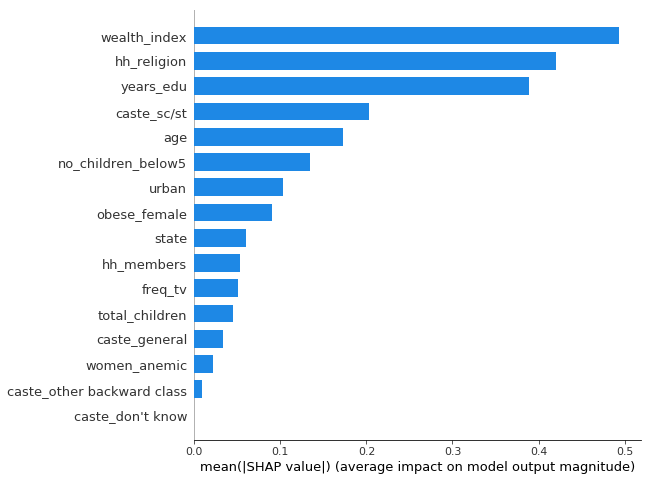

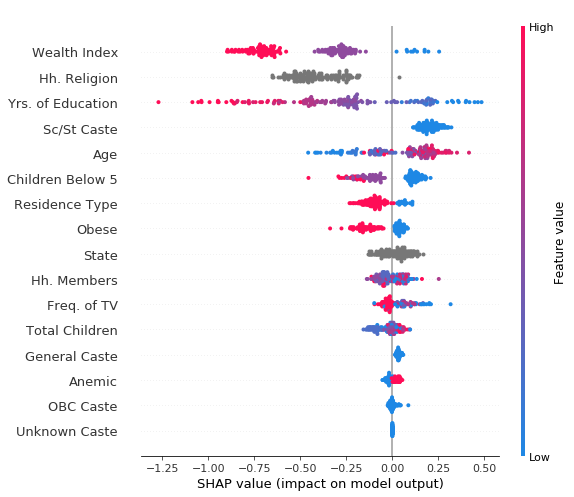


State: madhya pradesh
Sample size: 6829

state - 0.369624222813446
wealth_index - 0.40097380276685857
hh_religion - 0.09454205829284842
women_anemic - 0.009978007123667003
obese_female - 0.07272375884473194
urban - 0.136402944169838
freq_tv - 0.05258335976078062
age - 0.17692932523134025
years_edu - 0.39004129442905006
hh_members - 0.045289653630664554
no_children_below5 - 0.1517248459747605
total_children - 0.054079003485404245
caste_don't know - 0.0004287715067509503
caste_general - 0.06594845277518416
caste_other backward class - 0.010665591535257455
caste_sc/st - 0.1349785970171252


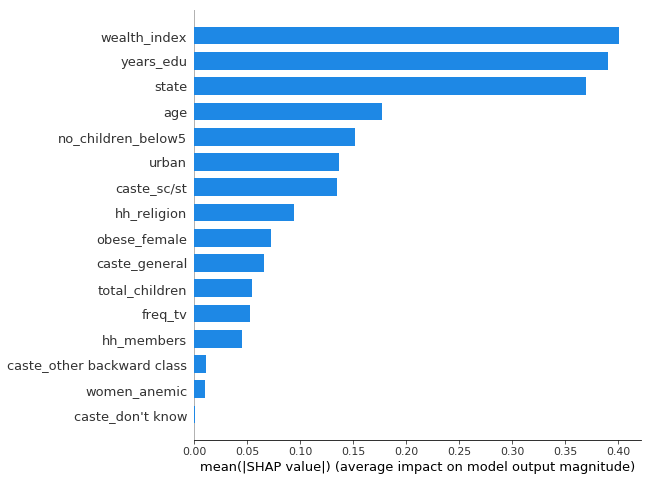

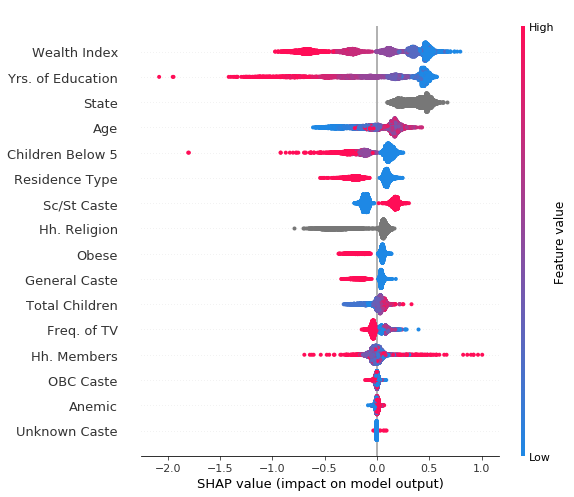


State: maharashtra
Sample size: 3368

state - 0.6064557876956548
wealth_index - 0.37930217540416794
hh_religion - 0.13691476052107518
women_anemic - 0.015444362178878868
obese_female - 0.10996902194834389
urban - 0.22028798452663825
freq_tv - 0.057802575482797776
age - 0.20942460031955062
years_edu - 0.3707103412897534
hh_members - 0.07039890627073718
no_children_below5 - 0.15452611112530873
total_children - 0.07282285423086227
caste_don't know - 0.0006938753349259013
caste_general - 0.05055478899730993
caste_other backward class - 0.01281271664400453
caste_sc/st - 0.09274274146716682


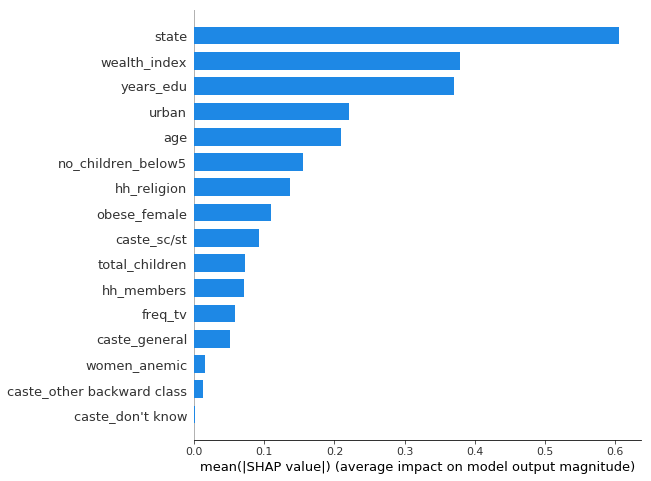

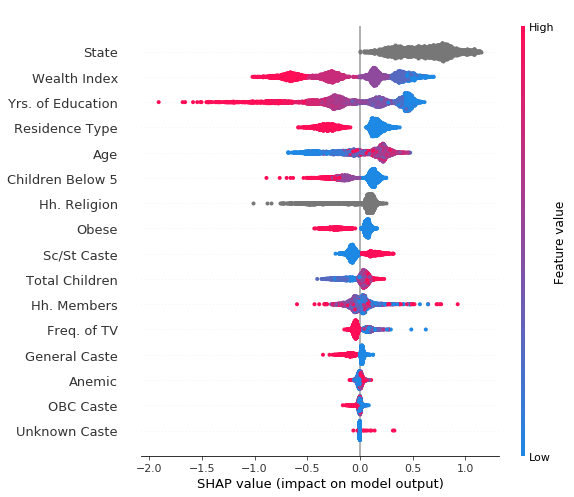


State: manipur
Sample size: 1417

state - 0.5597804816745778
wealth_index - 0.34095342027675396
hh_religion - 0.11437913676330612
women_anemic - 0.013537026203287011
obese_female - 0.11313382285566251
urban - 0.179368426739999
freq_tv - 0.06628847727891951
age - 0.19430244860147852
years_edu - 0.41396003483149596
hh_members - 0.047406499776713185
no_children_below5 - 0.1662621345677687
total_children - 0.07833509245747336
caste_don't know - 0.0010799374194875565
caste_general - 0.04773214568423364
caste_other backward class - 0.013518292950887342
caste_sc/st - 0.1297288533799016


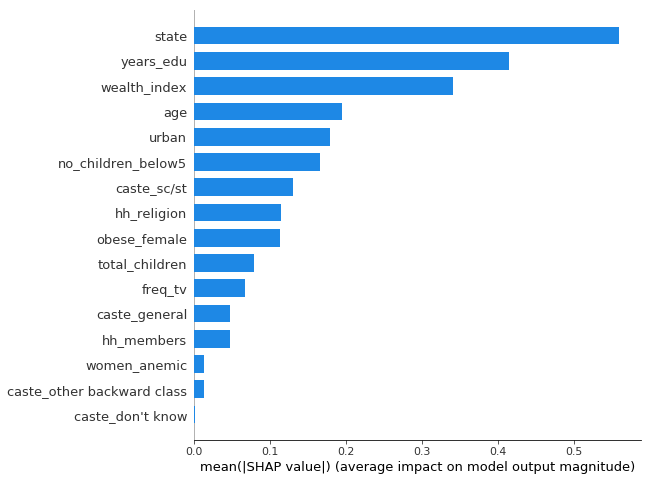

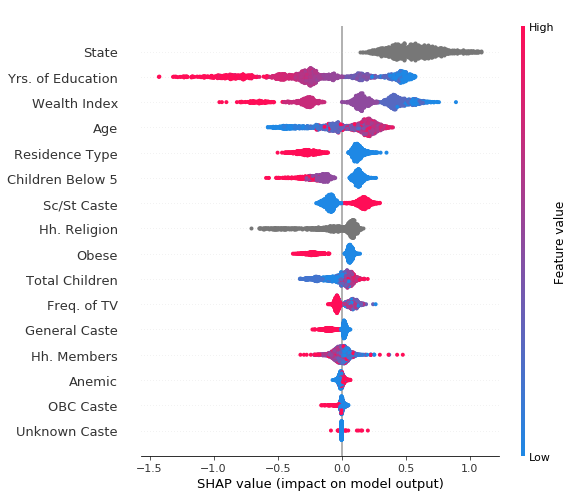


State: meghalaya
Sample size: 913

state - 0.3315428421854717
wealth_index - 0.3283792672779525
hh_religion - 0.06510894324529329
women_anemic - 0.016478731255555372
obese_female - 0.0816737744950791
urban - 0.11730878847466447
freq_tv - 0.06443963162363155
age - 0.2081072997021283
years_edu - 0.43035768308291356
hh_members - 0.03484503870741129
no_children_below5 - 0.17653354062760318
total_children - 0.07102622238126723
caste_don't know - 0.00022850780856182112
caste_general - 0.027257634867780125
caste_other backward class - 0.008923536116688313
caste_sc/st - 0.1883122584912121


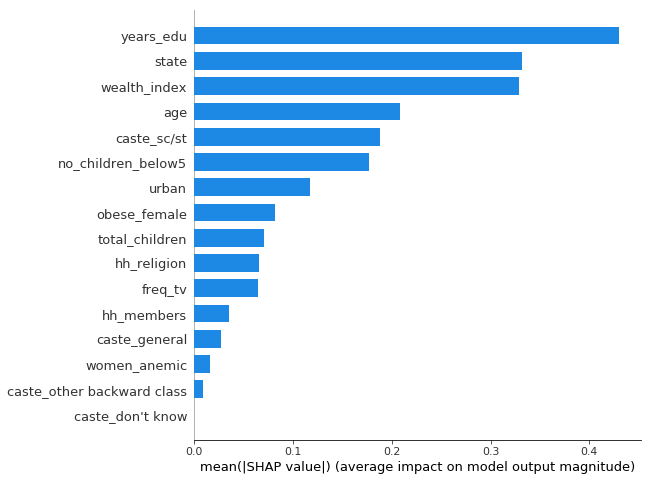

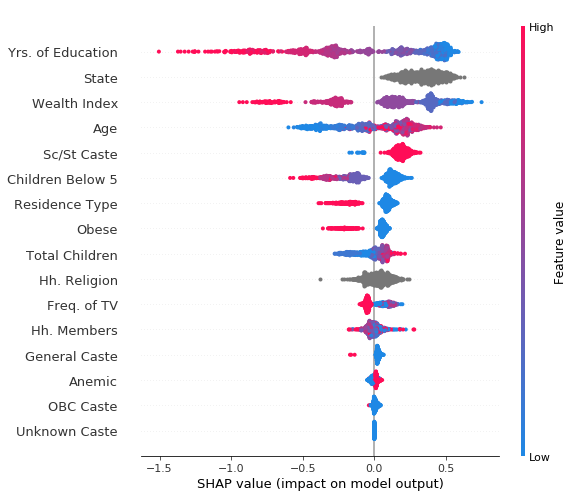


State: mizoram
Sample size: 1407

state - 0.2714130083555856
wealth_index - 0.4158690892753933
hh_religion - 0.06514346165305164
women_anemic - 0.019575295502922446
obese_female - 0.09043830255252425
urban - 0.14812091807245428
freq_tv - 0.06808349437699801
age - 0.1885992738481047
years_edu - 0.33477413936758726
hh_members - 0.04084941826330094
no_children_below5 - 0.16196272828271774
total_children - 0.06693843170369689
caste_don't know - 0.0006039706959974702
caste_general - 0.031548367480573325
caste_other backward class - 0.008809842904641088
caste_sc/st - 0.1935789152256819


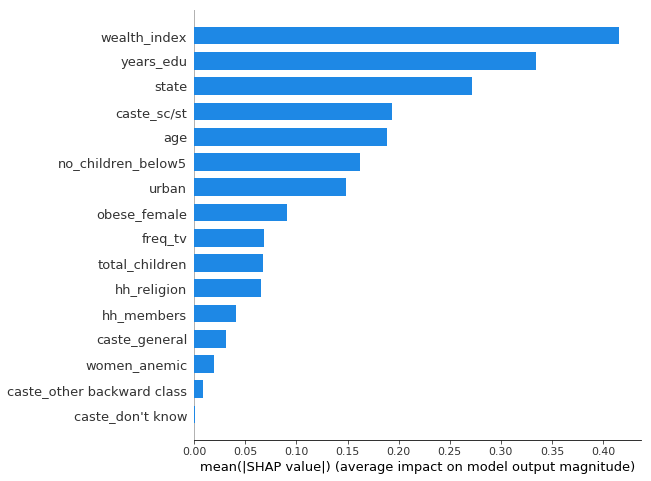

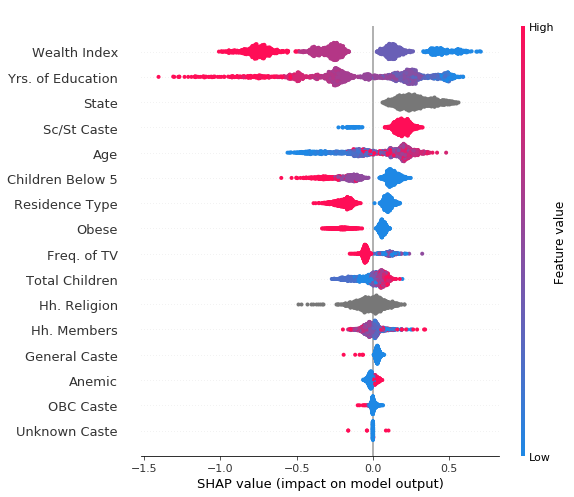


State: nagaland
Sample size: 1157

state - 0.06018350510223572
wealth_index - 0.32709722806603647
hh_religion - 0.0646877289716095
women_anemic - 0.01807079219674862
obese_female - 0.07960201885818446
urban - 0.09668448632698759
freq_tv - 0.06304921089191359
age - 0.15708891662223093
years_edu - 0.36692658702724085
hh_members - 0.032255144840953216
no_children_below5 - 0.16659738367625312
total_children - 0.059663713428597345
caste_don't know - 0.000268226305362019
caste_general - 0.03180746091800745
caste_other backward class - 0.006864890590916698
caste_sc/st - 0.1894795370621853


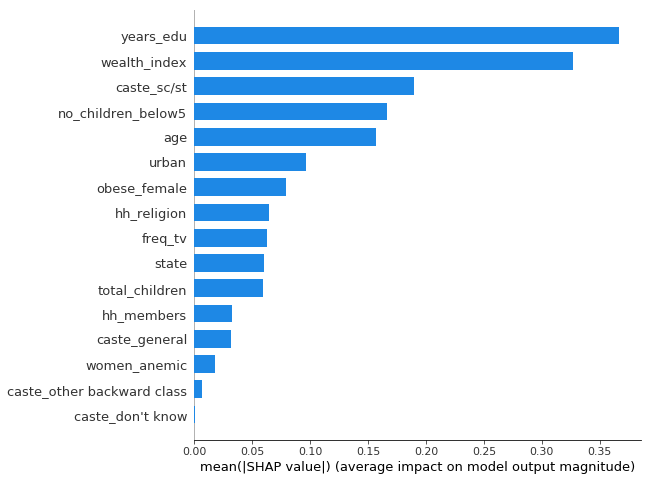

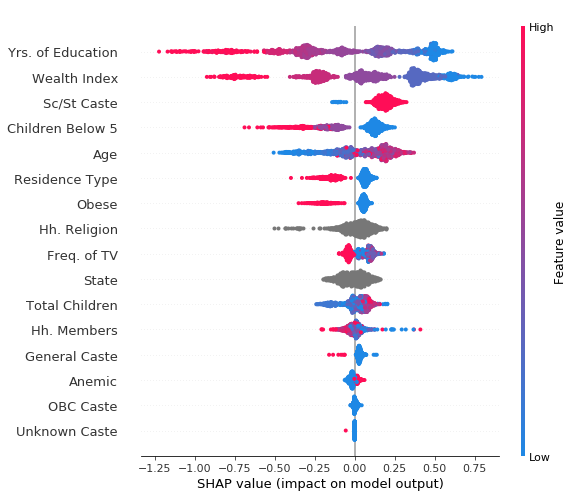


State: delhi
Sample size: 485

state - 0.0664359025576089
wealth_index - 0.5050147385977292
hh_religion - 0.12220798069420219
women_anemic - 0.013366995970015142
obese_female - 0.09617546770843402
urban - 0.1572537628960546
freq_tv - 0.04134910888154491
age - 0.17088031452116226
years_edu - 0.4134793881611817
hh_members - 0.06065033632855212
no_children_below5 - 0.14076473146317145
total_children - 0.058804301239787575
caste_don't know - 0.00193426594371495
caste_general - 0.07701452612782841
caste_other backward class - 0.009060709821616943
caste_sc/st - 0.11001116830012361


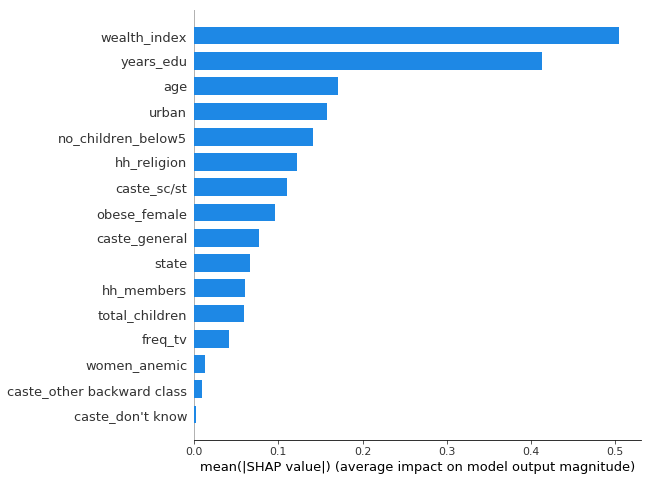

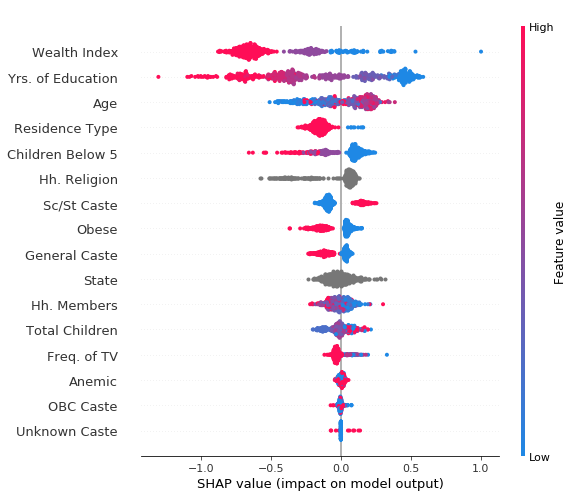


State: odisha
Sample size: 3864

state - 0.26613143332916744
wealth_index - 0.33380728550959954
hh_religion - 0.048443888634344096
women_anemic - 0.011750272420876786
obese_female - 0.057595883871486626
urban - 0.06401505101498853
freq_tv - 0.05338917074200195
age - 0.1502492334967521
years_edu - 0.3737436639050612
hh_members - 0.03260919088570426
no_children_below5 - 0.13080429397798185
total_children - 0.05357050837066218
caste_don't know - 0.000389551088020929
caste_general - 0.06524800406544057
caste_other backward class - 0.004940882757752032
caste_sc/st - 0.16030077908389392


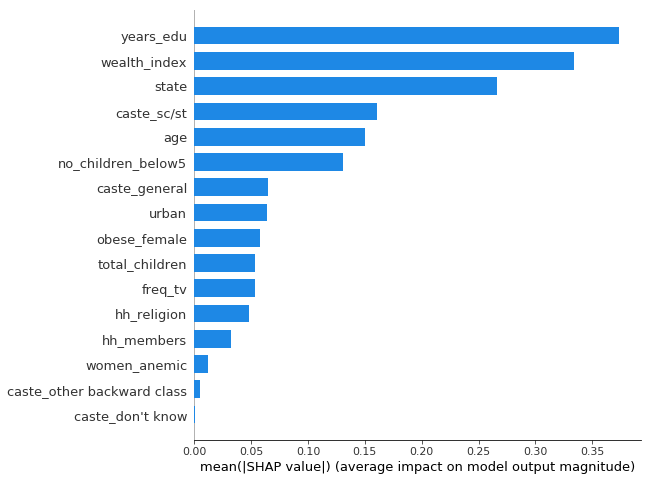

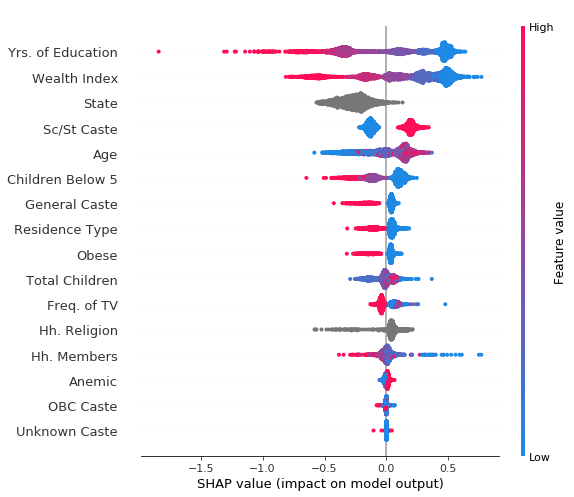


State: puducherry
Sample size: 645

state - 0.1293343308097334
wealth_index - 0.37107782824949204
hh_religion - 0.07864151542282184
women_anemic - 0.014923747635012561
obese_female - 0.08630594758716342
urban - 0.11140831684785828
freq_tv - 0.03600875952272648
age - 0.1557257037806181
years_edu - 0.44331369698389633
hh_members - 0.052874682487934935
no_children_below5 - 0.13533559667723902
total_children - 0.03917565524144033
caste_don't know - 0.000565228493541582
caste_general - 0.05266473310039688
caste_other backward class - 0.007235218632477082
caste_sc/st - 0.11799794584427886


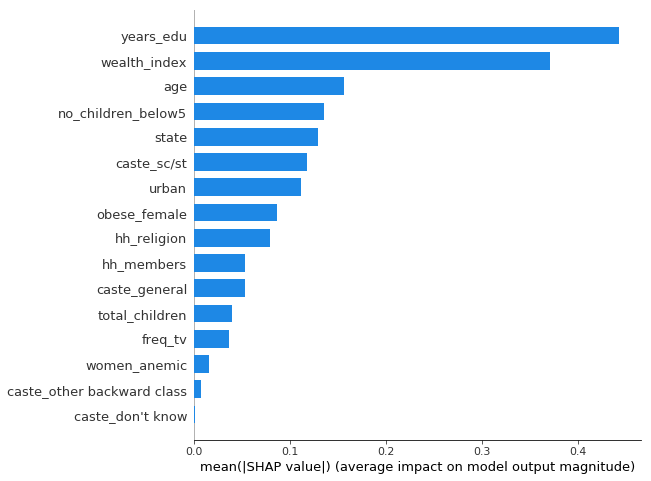

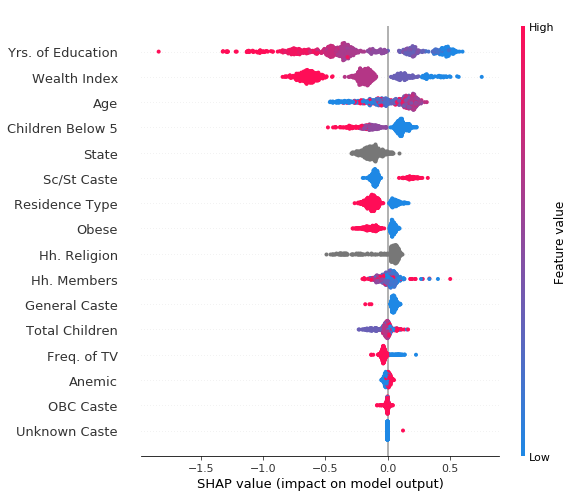


State: punjab
Sample size: 2319

state - 0.12897471618035375
wealth_index - 0.5017524276815744
hh_religion - 0.08621939245945687
women_anemic - 0.013239121279508595
obese_female - 0.06559569141306604
urban - 0.10221203028751365
freq_tv - 0.036016088096720085
age - 0.14031377298533093
years_edu - 0.4384116375567798
hh_members - 0.04296978322598703
no_children_below5 - 0.12273818869596505
total_children - 0.05352362227102635
caste_don't know - 0.00028581436159114864
caste_general - 0.10578963337802402
caste_other backward class - 0.014025870215457247
caste_sc/st - 0.1397235663100827


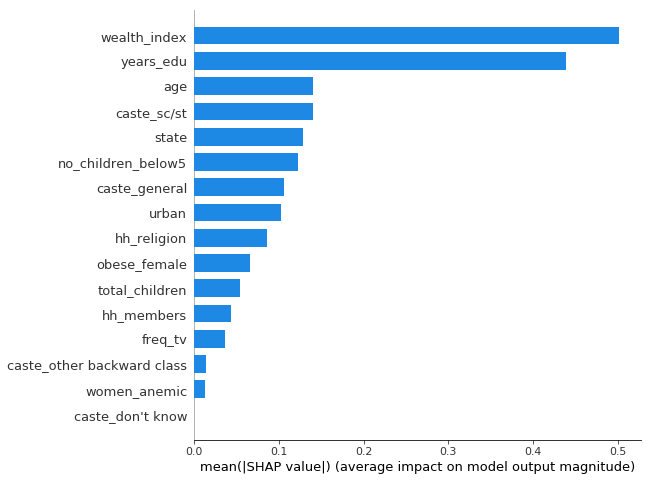

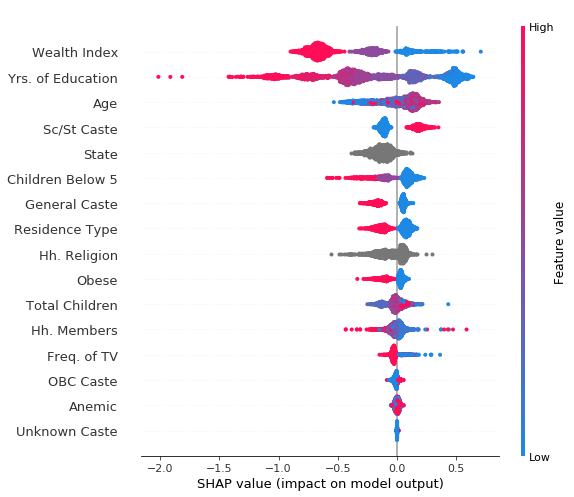


State: rajasthan
Sample size: 4556

state - 0.06140381114085114
wealth_index - 0.3728900488333791
hh_religion - 0.08754353982083724
women_anemic - 0.011062547215497784
obese_female - 0.06782035808272151
urban - 0.1109361883579402
freq_tv - 0.05506533553482964
age - 0.17372585787573588
years_edu - 0.3887598405030621
hh_members - 0.04319817154201248
no_children_below5 - 0.15078382232240528
total_children - 0.04919467449577388
caste_don't know - 0.0007119387047671949
caste_general - 0.08699364656091847
caste_other backward class - 0.013696603930959669
caste_sc/st - 0.10608028242349828


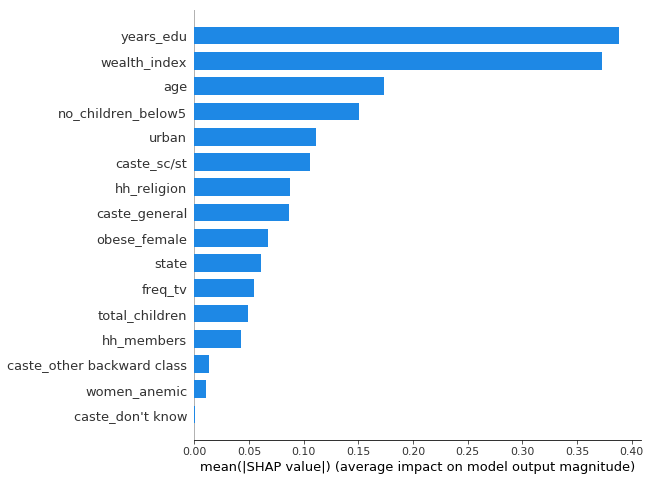

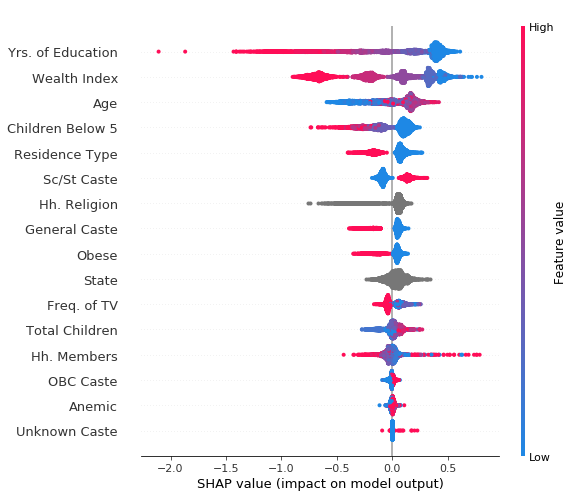


State: sikkim
Sample size: 707

state - 0.0424107808034476
wealth_index - 0.2469074293816026
hh_religion - 0.06058113445818572
women_anemic - 0.014852184743146733
obese_female - 0.0918809004086456
urban - 0.107136386117029
freq_tv - 0.04767038240649796
age - 0.16422096631634334
years_edu - 0.3837697656116101
hh_members - 0.03467279523308376
no_children_below5 - 0.13835311878708534
total_children - 0.060209520050051764
caste_don't know - 0.0002745119895329098
caste_general - 0.083419833411206
caste_other backward class - 0.009944433910933468
caste_sc/st - 0.14592467838237555


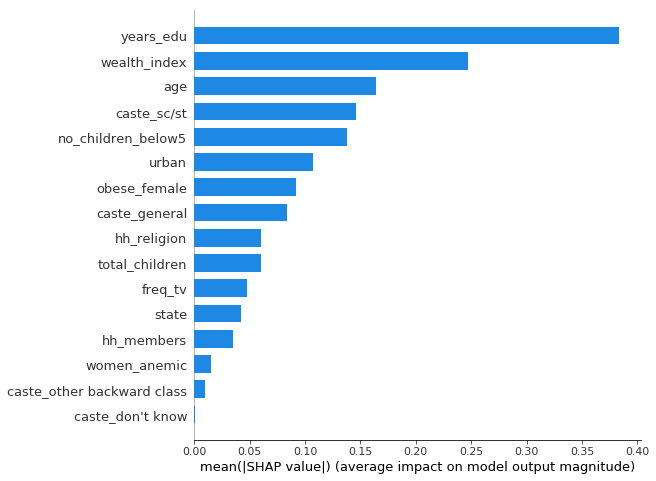

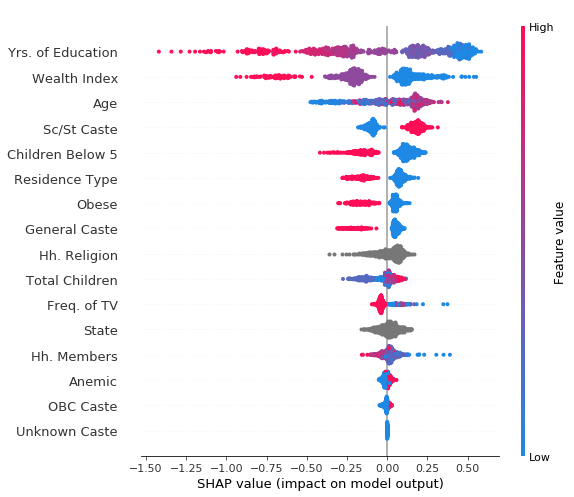


State: tamil nadu
Sample size: 4656

state - 0.17056466116461333
wealth_index - 0.3238553077864121
hh_religion - 0.08129006426775459
women_anemic - 0.009730893632456878
obese_female - 0.09453428670198495
urban - 0.13933927045884148
freq_tv - 0.027053216985020227
age - 0.19962822427580854
years_edu - 0.42985481519892926
hh_members - 0.04972586231787011
no_children_below5 - 0.15442707762191413
total_children - 0.06239522887023163
caste_don't know - 0.00032564179679108276
caste_general - 0.06165563338998451
caste_other backward class - 0.009534688528951299
caste_sc/st - 0.1110566464206766


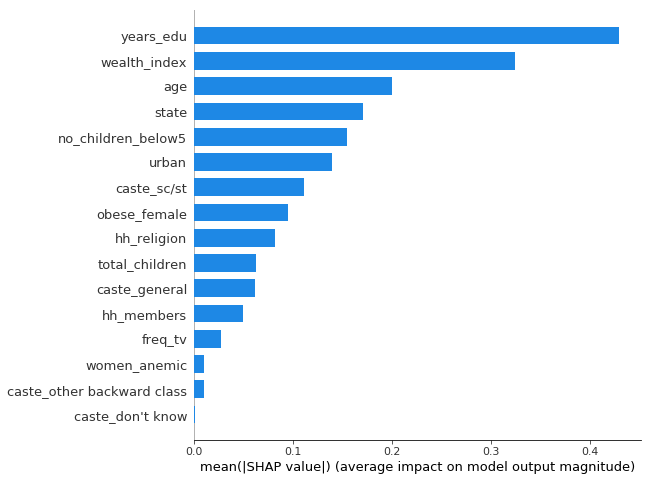

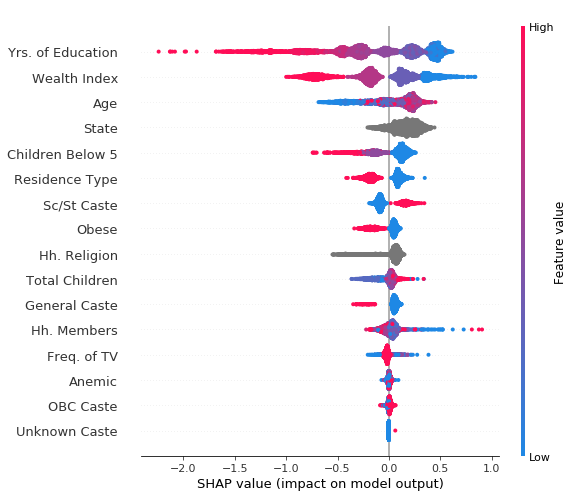


State: tripura
Sample size: 606

state - 0.06219790640913874
wealth_index - 0.3382215652175531
hh_religion - 0.05612237410092786
women_anemic - 0.009104613116699951
obese_female - 0.06242831699393062
urban - 0.08709005847643837
freq_tv - 0.04435835046451186
age - 0.19671093448871527
years_edu - 0.3078679867823866
hh_members - 0.03973391739246364
no_children_below5 - 0.14977223763568923
total_children - 0.061233380598468126
caste_don't know - 0.00023676922019364664
caste_general - 0.07667145793647166
caste_other backward class - 0.008461298971213973
caste_sc/st - 0.1646176494118753


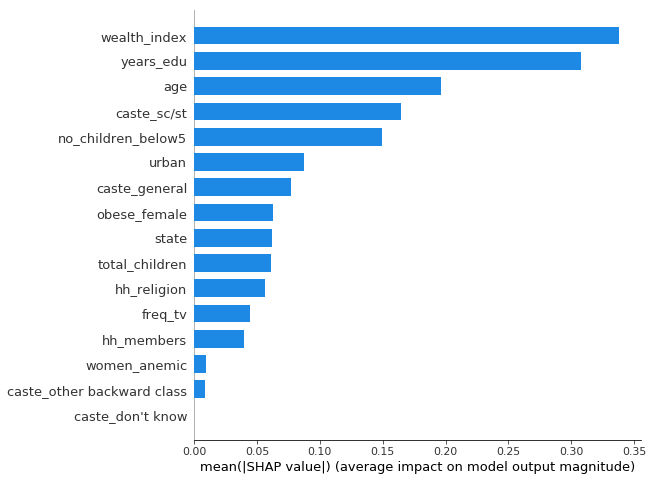

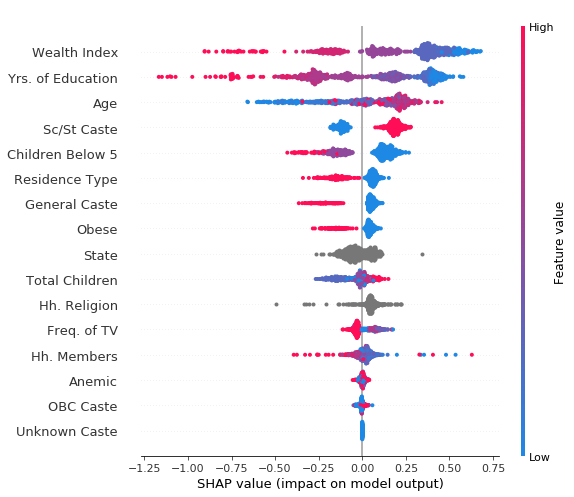


State: uttar pradesh
Sample size: 9903

state - 0.2736235345806395
wealth_index - 0.3212672852180114
hh_religion - 0.10008389697778557
women_anemic - 0.009836963750288566
obese_female - 0.06767513204709757
urban - 0.06966245469180597
freq_tv - 0.04690691176717608
age - 0.16968110686813462
years_edu - 0.3857643594062713
hh_members - 0.05548415944227355
no_children_below5 - 0.15708321070932116
total_children - 0.06791293359815558
caste_don't know - 0.000438918338522071
caste_general - 0.08938892961645428
caste_other backward class - 0.013454538771549267
caste_sc/st - 0.12955178627515415


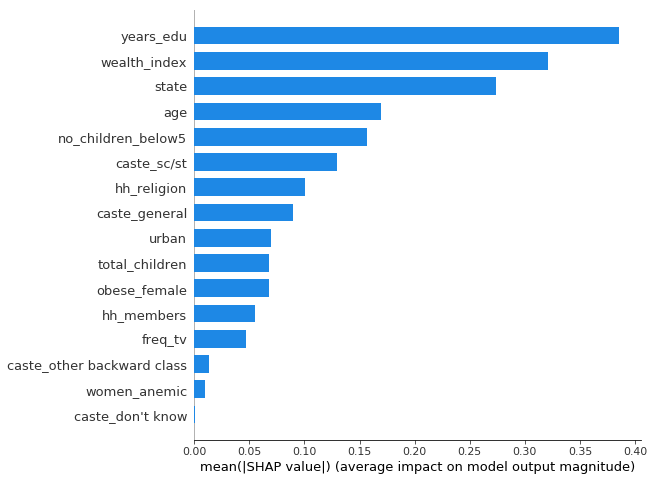

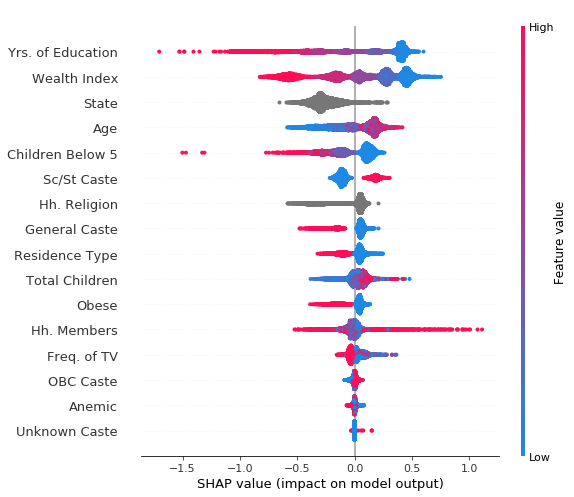


State: uttarakhand
Sample size: 1867

state - 0.24587735977376418
wealth_index - 0.2880508269004715
hh_religion - 0.07482272121580599
women_anemic - 0.02356932840862889
obese_female - 0.06696999173554599
urban - 0.07305400099123781
freq_tv - 0.046602930294750336
age - 0.1587714658700445
years_edu - 0.41365138780239075
hh_members - 0.04499800654370384
no_children_below5 - 0.14725063851532724
total_children - 0.05115791483933864
caste_don't know - 0.0007239372336347407
caste_general - 0.11758700368862127
caste_other backward class - 0.012569998592613109
caste_sc/st - 0.1300501545092214


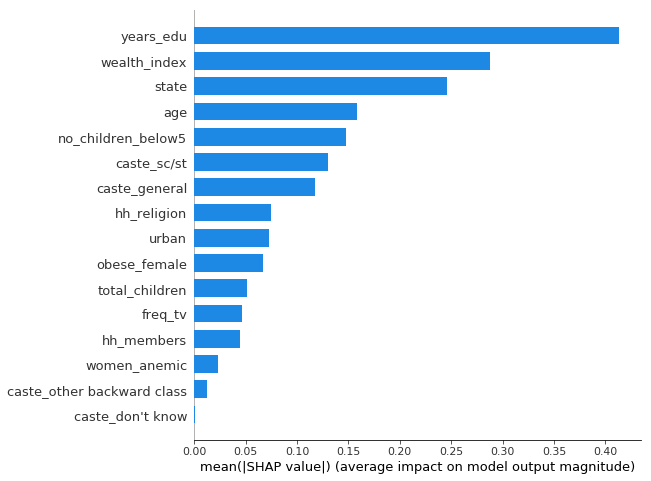

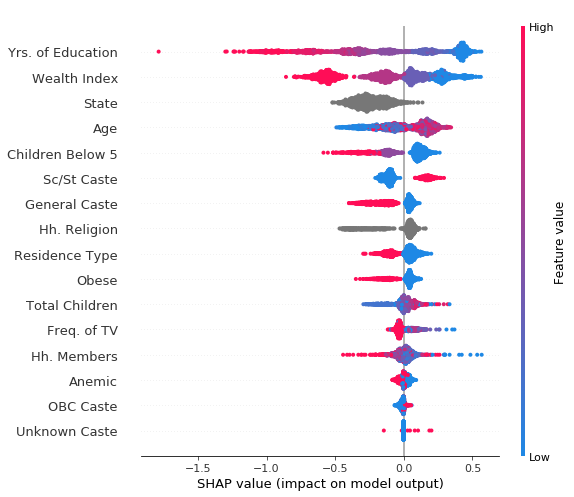


State: west bengal
Sample size: 1706

state - 0.4322157810796832
wealth_index - 0.270192774139585
hh_religion - 0.07844500108500936
women_anemic - 0.023352538553051562
obese_female - 0.06709821062053514
urban - 0.06364040780284791
freq_tv - 0.03780473472945449
age - 0.16513204518397337
years_edu - 0.40629151095133886
hh_members - 0.06509793042593245
no_children_below5 - 0.15722140635219678
total_children - 0.06150820103659586
caste_don't know - 0.0007694274984954198
caste_general - 0.1188993068515024
caste_other backward class - 0.01256144276748814
caste_sc/st - 0.158036656047285


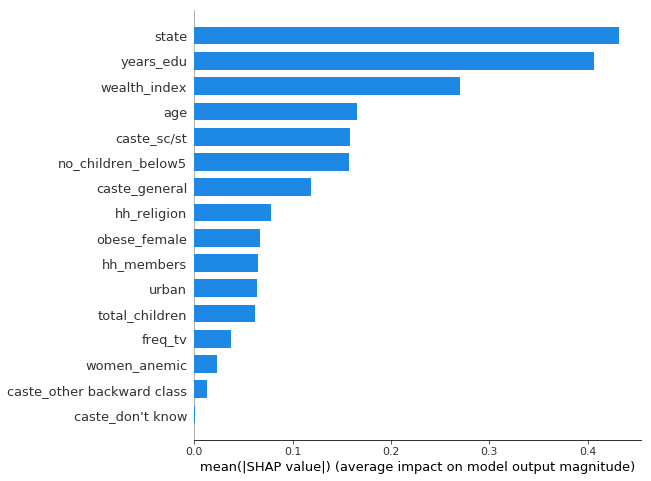

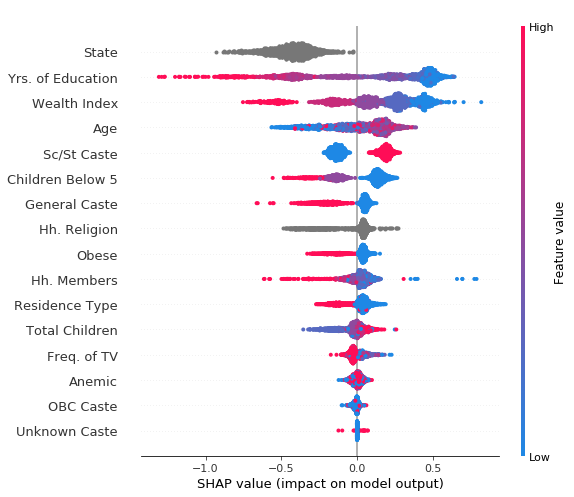


State: telangana
Sample size: 885

state - 0.8629844649587618
wealth_index - 0.37486660157451684
hh_religion - 0.09981152909062722
women_anemic - 0.02234690700445403
obese_female - 0.14735142794013448
urban - 0.23763289249887015
freq_tv - 0.0270182762028045
age - 0.15972702055228022
years_edu - 0.536216879513408
hh_members - 0.0670860529567099
no_children_below5 - 0.1253833797732153
total_children - 0.06766491475309423
caste_don't know - 0.000804568327568678
caste_general - 0.06539593497225916
caste_other backward class - 0.014051494871218475
caste_sc/st - 0.11097440857698831


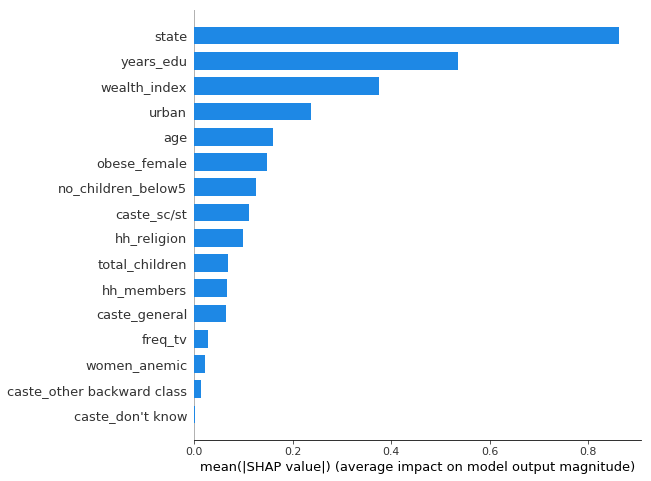

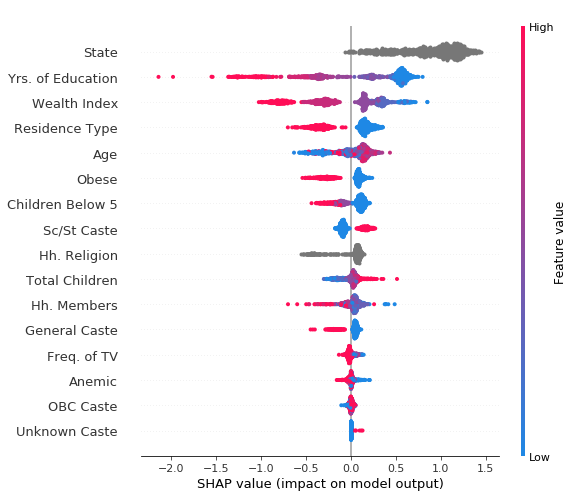

In [36]:
for state, state_display in zip(dataset.state.unique(), dataset_display.State.unique()):
    # Sample dataset by state
    dataset_sample = dataset[dataset.state==state]
    dataset_display_sample = dataset_display[dataset.state==state]
    targets_sample = targets[dataset.state==state]
    shap_values_sample = shap_values[dataset.state==state]
    
    print("\nState: {}".format(state_display))
    print("Sample size: {}\n".format(len(dataset_sample)))
    
    for col, sv in zip(dataset_sample.columns, np.abs(shap_values_sample).mean(0)):
        print(f"{col} - {sv}")
    
    # Summary plots
    shap.summary_plot(shap_values_sample, dataset_sample, plot_type="bar")
    shap.summary_plot(shap_values_sample, dataset_display_sample)

---

### SHAP Interaction Values

SHAP interaction values are a generalization of SHAP values to higher order interactions. 

The model returns a matrix for every prediction, where the main effects are on the diagonal and the interaction effects are off-diagonal. The main effects are similar to the SHAP values you would get for a linear model, and the interaction effects captures all the higher-order interactions are divide them up among the pairwise interaction terms. 

Note that the sum of the entire interaction matrix is the difference between the model's current output and expected output, and so the interaction effects on the off-diagonal are split in half (since there are two of each). When plotting interaction effects the SHAP package automatically multiplies the off-diagonal values by two to get the full interaction effect.

In [42]:
# Sample from dataset based on sample weights
dataset_ss = dataset.sample(10000, weights=sample_weights, random_state=random_state)
print(dataset_ss.shape)
dataset_display_ss = dataset_display.loc[dataset_ss.index]
print(dataset_display_ss.shape)

(10000, 16)
(10000, 16)


In [43]:
# Compute SHAP interaction values (time consuming)
# shap_interaction_values = explainer.shap_interaction_values(dataset_ss)
shap_interaction_values = pickle.load(open(f'res/{target_col}-{year}-shapints.obj', 'rb'))

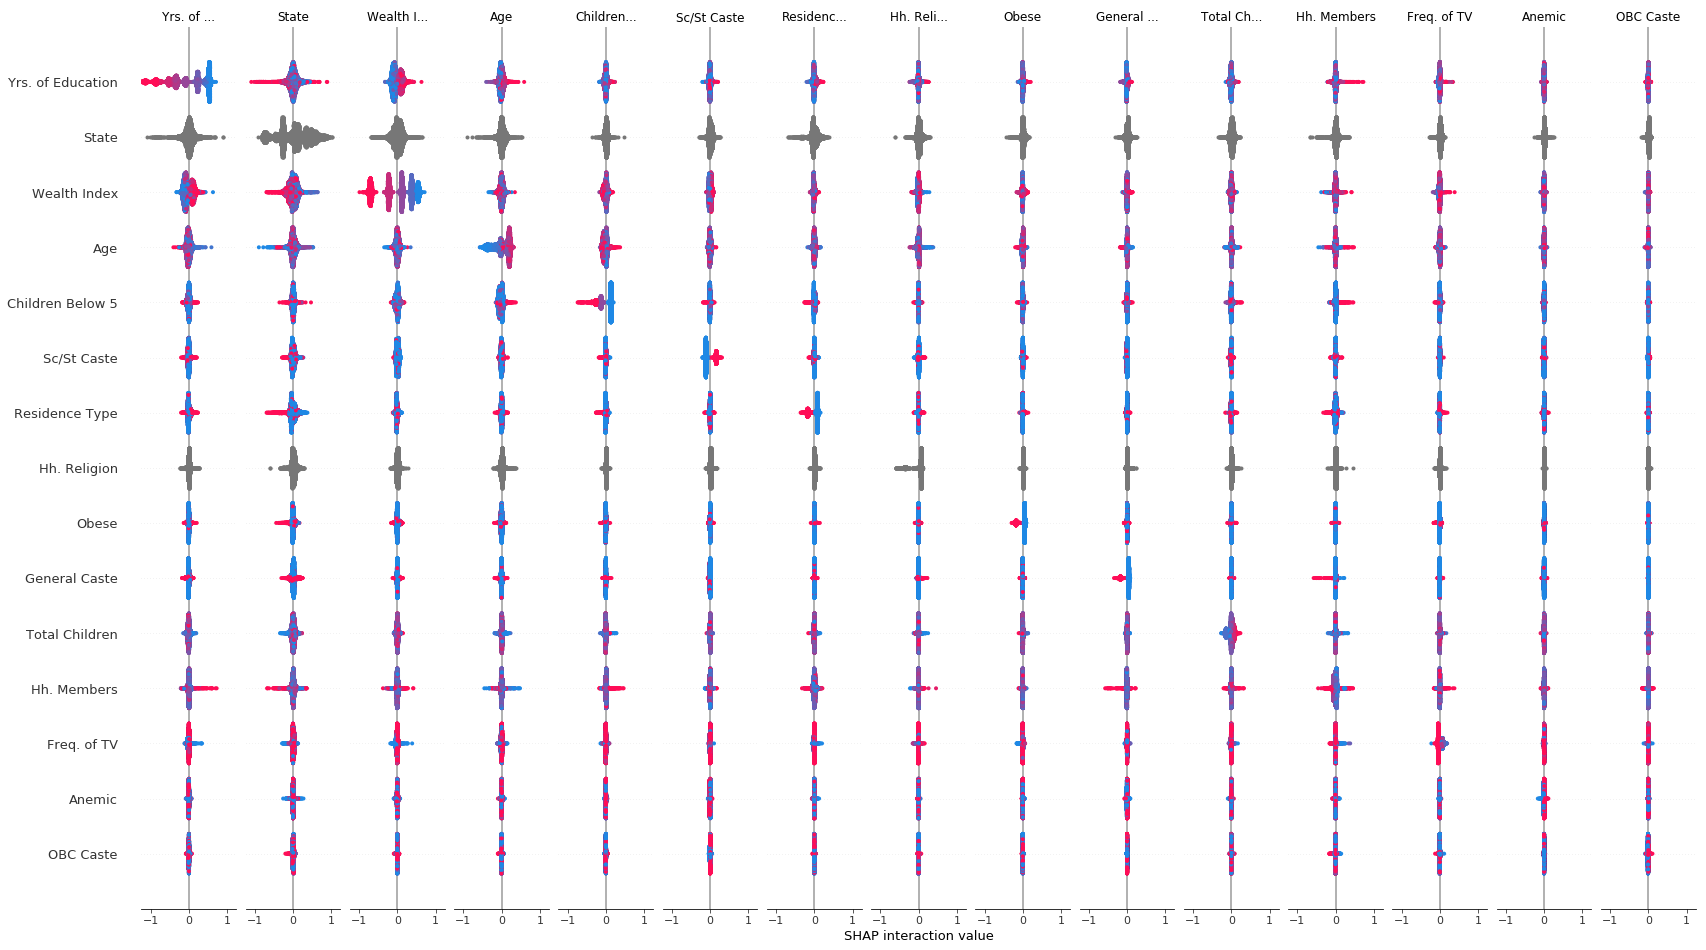

In [44]:
shap.summary_plot(shap_interaction_values, dataset_display_ss, max_display=15)

### Heatmap of SHAP Interaction Values

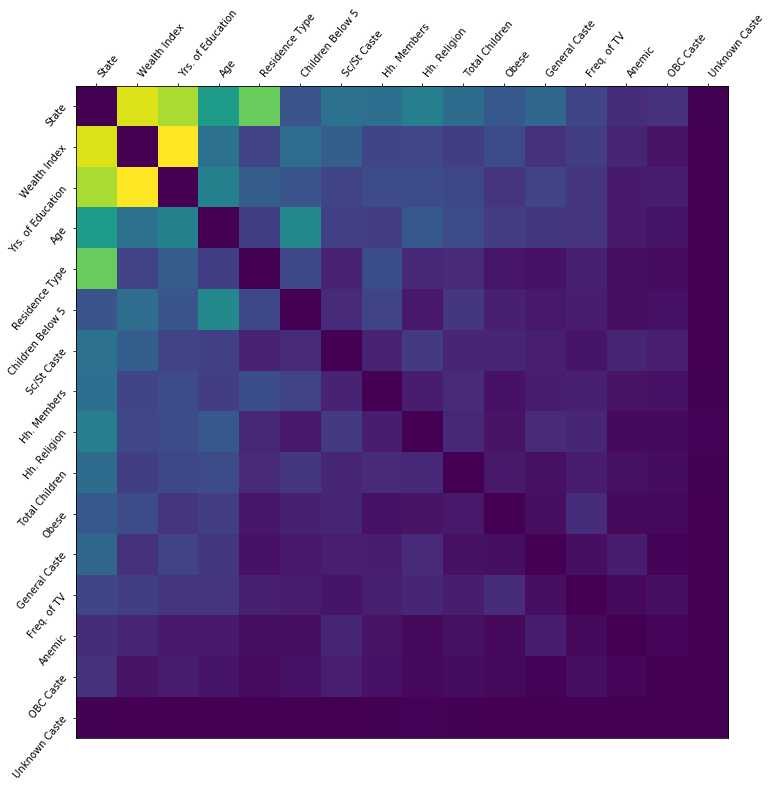

In [45]:
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
pl.figure(figsize=(12,12))
pl.imshow(tmp2)
pl.yticks(range(tmp2.shape[0]), dataset_display_ss.columns[inds], rotation=50.4, horizontalalignment="right")
pl.xticks(range(tmp2.shape[0]), dataset_display_ss.columns[inds], rotation=50.4, horizontalalignment="left")
pl.gca().xaxis.tick_top()
pl.show()

### SHAP Interaction Value Dependence Plots

Running a dependence plot on the SHAP interaction values a allows us to separately observe the main effects and the interaction effects.

Below we plot the main effects for age and some of the interaction effects for age. It is informative to compare the main effects plot of age with the earlier SHAP value plot for age. The main effects plot has no vertical dispersion because the interaction effects are all captured in the off-diagonal terms.

**Good example of how to infer interesting stuff from interaction values: https://slundberg.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html**

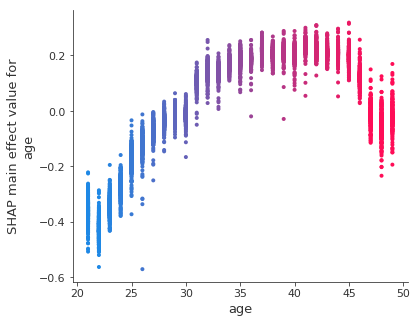

In [46]:
shap.dependence_plot(
    ("age", "age"), 
    shap_interaction_values, dataset_ss, display_features=dataset_display_ss
)

Now we plot the interaction effects involving age (and other features after that). These effects capture all of the vertical dispersion that was present in the original SHAP plot but is missing from the main effects plot above.

#### Plots for 'age'


Feature: age, Interaction Feature: age


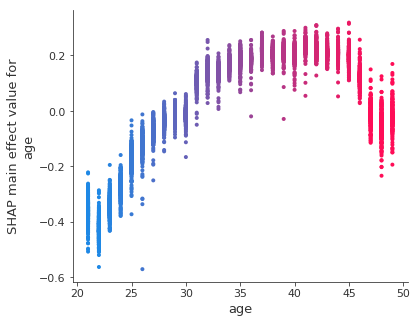


Feature: age, Interaction Feature: urban


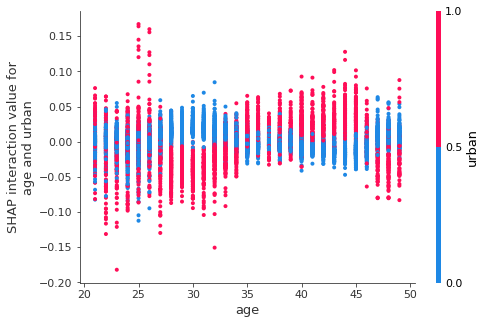


Feature: age, Interaction Feature: caste_sc/st


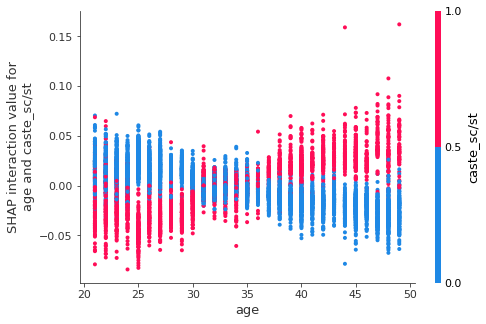


Feature: age, Interaction Feature: caste_general


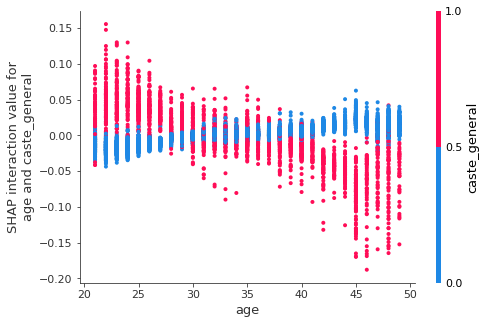


Feature: age, Interaction Feature: wealth_index


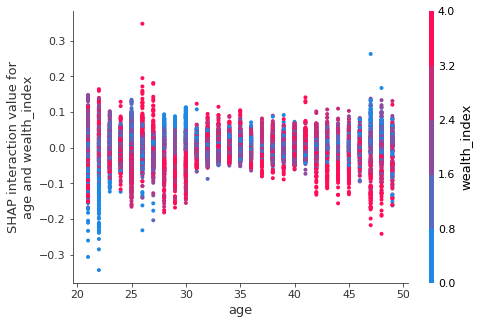


Feature: age, Interaction Feature: years_edu


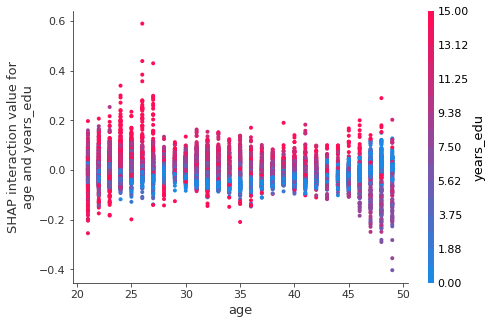


Feature: age, Interaction Feature: no_children_below5


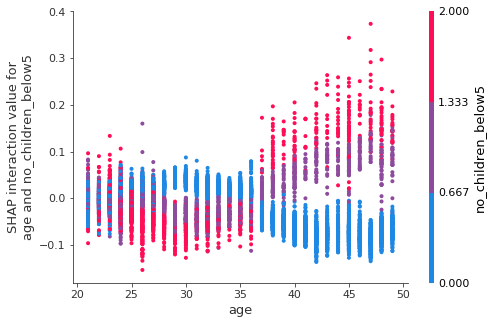


Feature: age, Interaction Feature: total_children


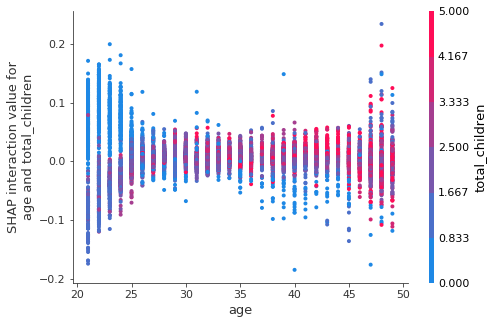

In [47]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('age', 'age'),
         ('age', 'urban'),
         ('age', 'caste_sc/st'),
         ('age', 'caste_general'),
         ('age', 'wealth_index'),
         ('age', 'years_edu'),
         ('age', 'no_children_below5'),
         ('age', 'total_children')]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(
        (col_name, int_col_name), 
        shap_interaction_values, dataset_ss, display_features=dataset_display_ss
    )

#### Plots for 'wealth_index'


Feature: wealth_index, Interaction Feature: wealth_index


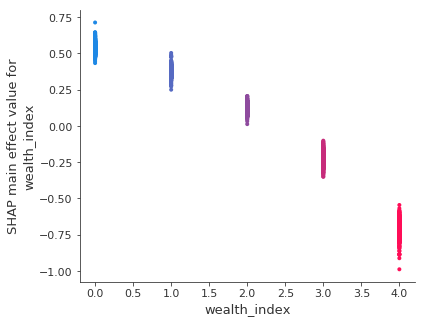


Feature: wealth_index, Interaction Feature: age


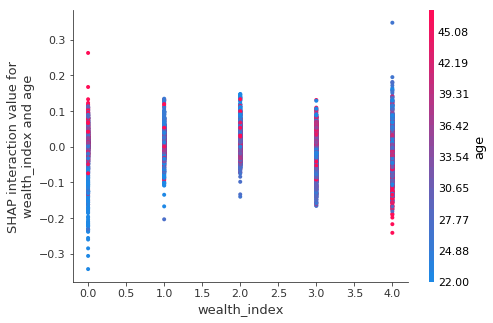


Feature: wealth_index, Interaction Feature: urban


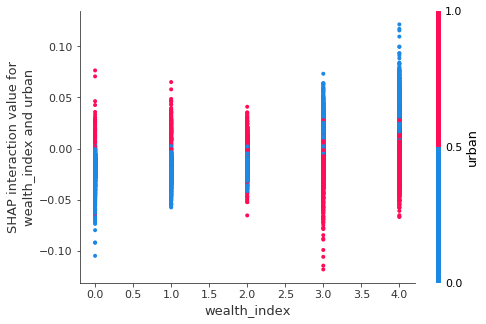


Feature: wealth_index, Interaction Feature: caste_sc/st


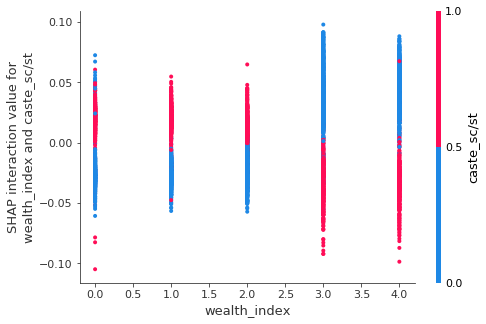


Feature: wealth_index, Interaction Feature: caste_general


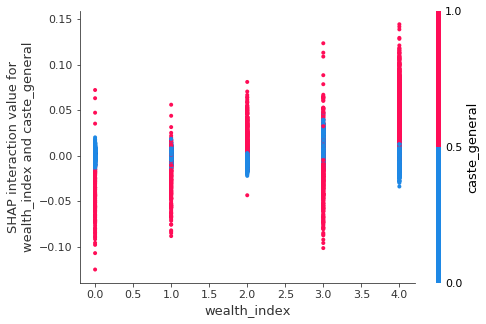


Feature: wealth_index, Interaction Feature: years_edu


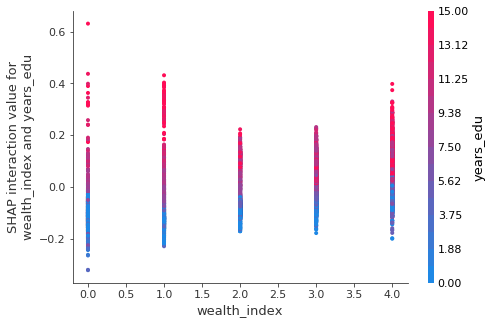


Feature: wealth_index, Interaction Feature: no_children_below5


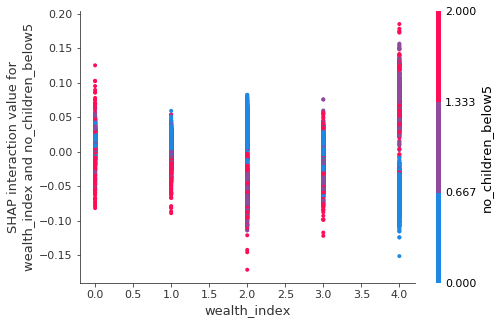


Feature: wealth_index, Interaction Feature: total_children


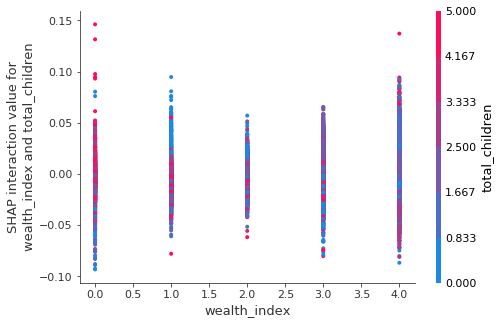

In [48]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('wealth_index', 'wealth_index'),
         ('wealth_index', 'age'), 
         ('wealth_index', 'urban'),
         ('wealth_index', 'caste_sc/st'),
         ('wealth_index', 'caste_general'),
         ('wealth_index', 'years_edu'),
         ('wealth_index', 'no_children_below5'),
         ('wealth_index', 'total_children')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(
        (col_name, int_col_name), 
        shap_interaction_values, dataset_ss, display_features=dataset_display_ss
    )

#### Plots for 'years_edu'


Feature: years_edu, Interaction Feature: years_edu


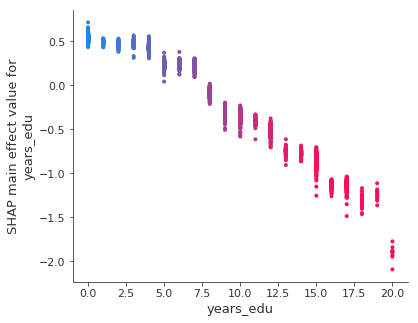


Feature: years_edu, Interaction Feature: age


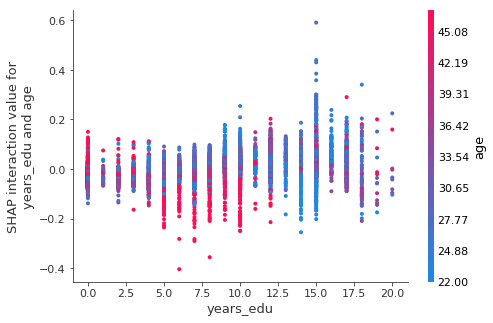


Feature: years_edu, Interaction Feature: urban


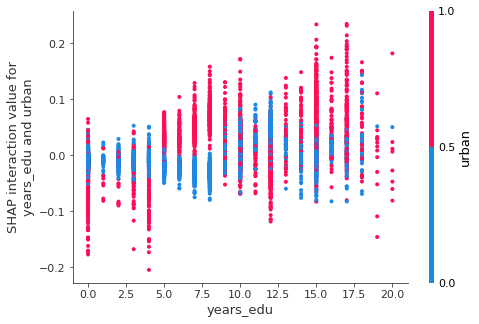


Feature: years_edu, Interaction Feature: caste_sc/st


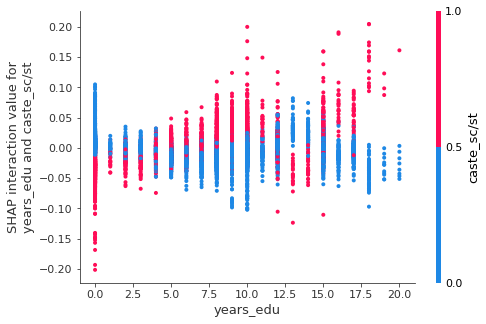


Feature: years_edu, Interaction Feature: caste_general


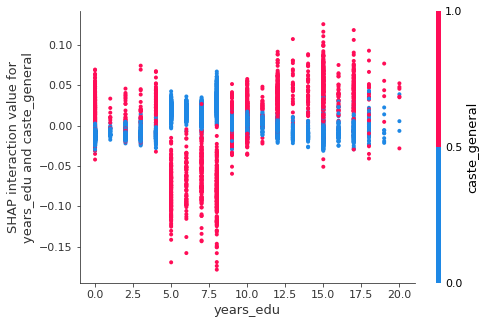


Feature: years_edu, Interaction Feature: wealth_index


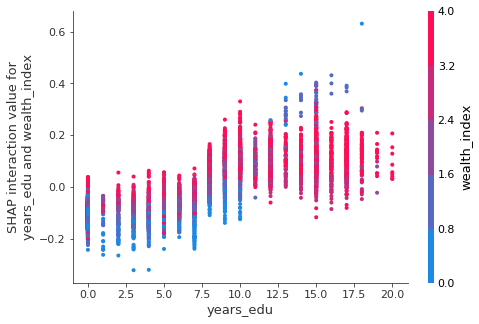


Feature: years_edu, Interaction Feature: no_children_below5


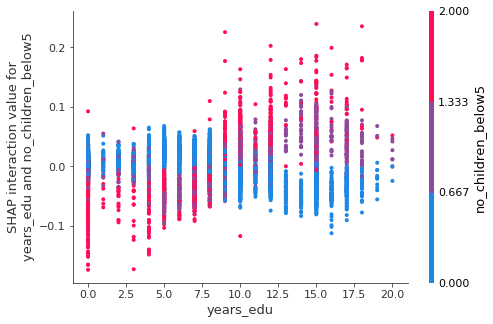


Feature: years_edu, Interaction Feature: total_children


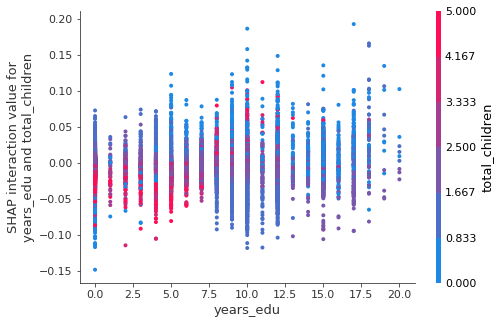

In [49]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('years_edu', 'years_edu'),
         ('years_edu', 'age'), 
         ('years_edu', 'urban'),
         ('years_edu', 'caste_sc/st'),
         ('years_edu', 'caste_general'),
         ('years_edu', 'wealth_index'),
         ('years_edu', 'no_children_below5'),
         ('years_edu', 'total_children')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(
        (col_name, int_col_name), 
        shap_interaction_values, dataset_ss, display_features=dataset_display_ss
    )

#### Plots for 'caste_sc/st'


Feature: caste_sc/st, Interaction Feature: caste_sc/st


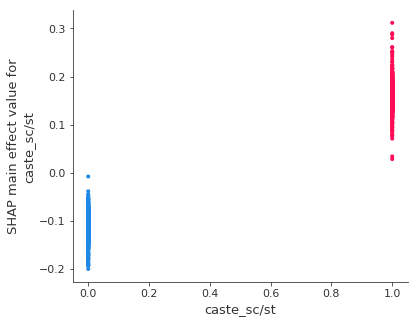


Feature: caste_sc/st, Interaction Feature: age


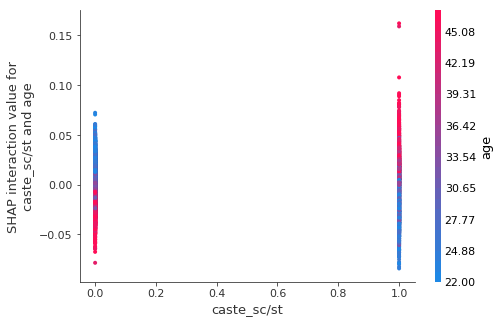


Feature: caste_sc/st, Interaction Feature: urban


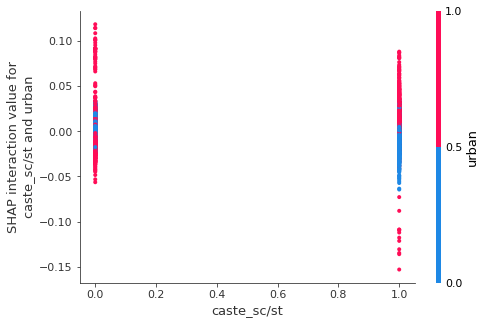


Feature: caste_sc/st, Interaction Feature: years_edu


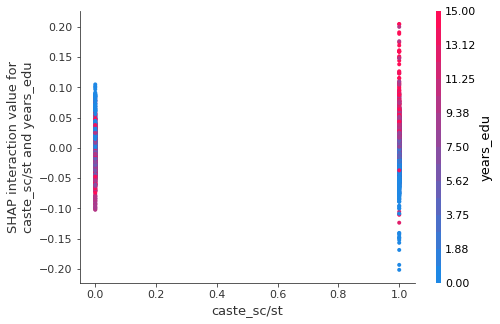


Feature: caste_sc/st, Interaction Feature: wealth_index


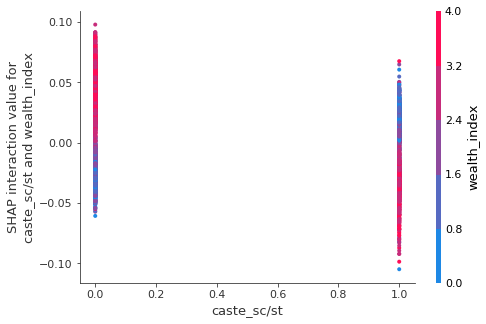


Feature: caste_sc/st, Interaction Feature: no_children_below5


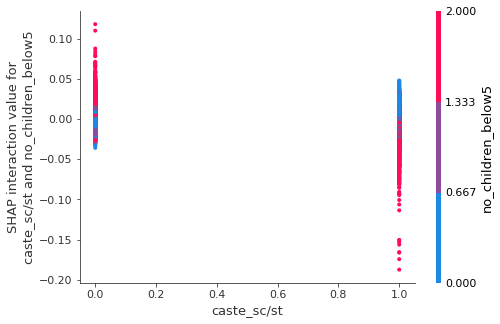


Feature: caste_sc/st, Interaction Feature: total_children


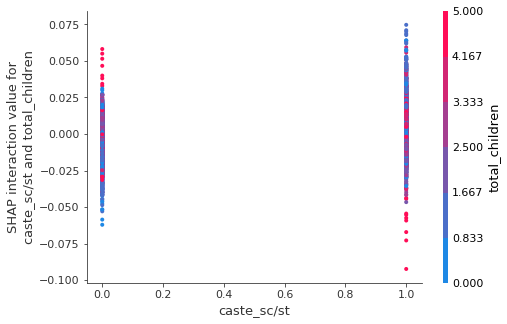

In [50]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('caste_sc/st', 'caste_sc/st'),
         ('caste_sc/st', 'age'), 
         ('caste_sc/st', 'urban'),
         ('caste_sc/st', 'years_edu'),
         ('caste_sc/st', 'wealth_index'),
         ('caste_sc/st', 'no_children_below5'),
         ('caste_sc/st', 'total_children')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(
        (col_name, int_col_name), 
        shap_interaction_values, dataset_ss, display_features=dataset_display_ss
    )

#### Plots for 'caste_general'


Feature: caste_general, Interaction Feature: caste_general


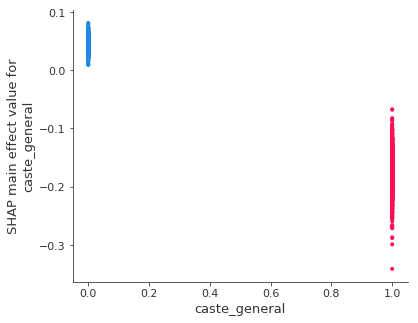


Feature: caste_general, Interaction Feature: age


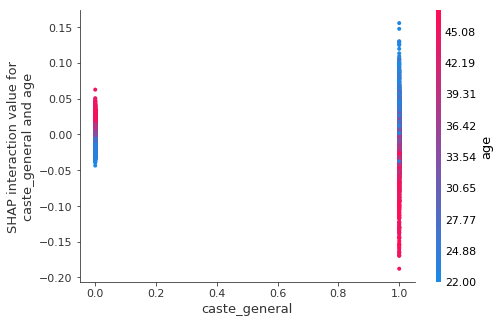


Feature: caste_general, Interaction Feature: urban


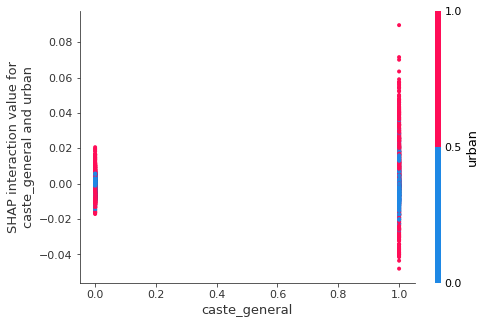


Feature: caste_general, Interaction Feature: years_edu


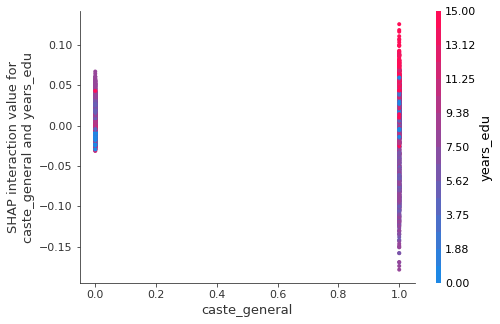


Feature: caste_general, Interaction Feature: wealth_index


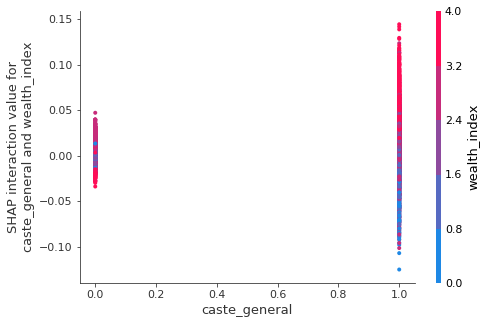


Feature: caste_general, Interaction Feature: no_children_below5


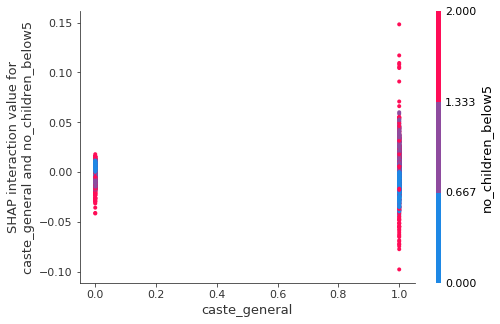


Feature: caste_general, Interaction Feature: total_children


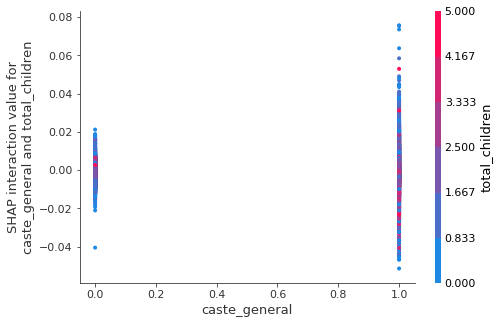

In [51]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('caste_general', 'caste_general'),
         ('caste_general', 'age'), 
         ('caste_general', 'urban'),
         ('caste_general', 'years_edu'),
         ('caste_general', 'wealth_index'),
         ('caste_general', 'no_children_below5'),
         ('caste_general', 'total_children'),
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(
        (col_name, int_col_name), 
        shap_interaction_values, dataset_ss, display_features=dataset_display_ss
    )